In [1]:
import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHash

name = 'FNN-Classification-Simple'

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 10,
}

HASH = getHash(name,[architecture,props])
print(HASH)

FNN-Classification-Simple-sigmoid_100000_1024_512_256_128_0001_CCE_10_1_0_0_1_0_e_e_0_1_0_basal_seg_data_norm_b25_roi_t1_native_k5_b25_t1_0_42_n_native_08_0_05_n


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(878801, 198)
(878801, 3)
validation
(151459, 198)
(151459, 3)
test
(112754, 198)
(112754, 3)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/'+props['space']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASH),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 198)]             0         


 dense (Dense)               (None, 1024)              203776    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 3)                 387       


Total params: 893187 (3.41 MB)


Trainable params: 893187 (3.41 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASH)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASH), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASH))

Epoch 1/10000


1/9 [==>...........................] - ETA: 45s - loss: 1.6491 - STD: 0.2777 - MAE: 0.4784

2/9 [=====>........................] - ETA: 0s - loss: 1.4390 - STD: 0.2026 - MAE: 0.4651 

3/9 [=========>....................] - ETA: 0s - loss: 1.3230 - STD: 0.1681 - MAE: 0.4544

4/9 [============>.................] - ETA: 0s - loss: 1.2648 - STD: 0.1567 - MAE: 0.4475

5/9 [===============>..............] - ETA: 0s - loss: 1.2391 - STD: 0.1562 - MAE: 0.4430

6/9 [===================>..........] - ETA: 2s - loss: 1.2292 - STD: 0.1590 - MAE: 0.4398

7/9 [======================>.......] - ETA: 1s - loss: 1.2217 - STD: 0.1613 - MAE: 0.4375

8/9 [=========================>....] - ETA: 0s - loss: 1.2144 - STD: 0.1623 - MAE: 0.4355

9/9 [==============================] - ETA: 0s - loss: 1.2070 - STD: 0.1624 - MAE: 0.4340

9/9 [==============================] - 12s 814ms/step - loss: 1.2070 - STD: 0.1624 - MAE: 0.4340 - val_loss: 1.1293 - val_STD: 0.1571 - val_MAE: 0.4216


Epoch 2/10000


1/9 [==>...........................] - ETA: 1s - loss: 1.1315 - STD: 0.1571 - MAE: 0.4219

2/9 [=====>........................] - ETA: 0s - loss: 1.1225 - STD: 0.1519 - MAE: 0.4227

3/9 [=========>....................] - ETA: 0s - loss: 1.1125 - STD: 0.1446 - MAE: 0.4236

4/9 [============>.................] - ETA: 0s - loss: 1.1045 - STD: 0.1350 - MAE: 0.4249

5/9 [===============>..............] - ETA: 0s - loss: 1.0982 - STD: 0.1238 - MAE: 0.4265

6/9 [===================>..........] - ETA: 0s - loss: 1.0945 - STD: 0.1117 - MAE: 0.4282

7/9 [======================>.......] - ETA: 0s - loss: 1.0929 - STD: 0.0998 - MAE: 0.4299

8/9 [=========================>....] - ETA: 0s - loss: 1.0928 - STD: 0.0893 - MAE: 0.4315

9/9 [==============================] - ETA: 0s - loss: 1.0933 - STD: 0.0811 - MAE: 0.4329

9/9 [==============================] - 1s 147ms/step - loss: 1.0933 - STD: 0.0811 - MAE: 0.4329 - val_loss: 1.0978 - val_STD: 0.0213 - val_MAE: 0.4437


Epoch 3/10000


1/9 [==>...........................] - ETA: 1s - loss: 1.0972 - STD: 0.0213 - MAE: 0.4436

2/9 [=====>........................] - ETA: 0s - loss: 1.0958 - STD: 0.0250 - MAE: 0.4431

3/9 [=========>....................] - ETA: 0s - loss: 1.0932 - STD: 0.0297 - MAE: 0.4422

4/9 [============>.................] - ETA: 0s - loss: 1.0906 - STD: 0.0351 - MAE: 0.4413

5/9 [===============>..............] - ETA: 0s - loss: 1.0885 - STD: 0.0408 - MAE: 0.4403

6/9 [===================>..........] - ETA: 0s - loss: 1.0862 - STD: 0.0462 - MAE: 0.4393

7/9 [======================>.......] - ETA: 0s - loss: 1.0845 - STD: 0.0511 - MAE: 0.4383

8/9 [=========================>....] - ETA: 0s - loss: 1.0831 - STD: 0.0553 - MAE: 0.4375

9/9 [==============================] - ETA: 0s - loss: 1.0822 - STD: 0.0591 - MAE: 0.4368

9/9 [==============================] - 1s 138ms/step - loss: 1.0822 - STD: 0.0591 - MAE: 0.4368 - val_loss: 1.0757 - val_STD: 0.0920 - val_MAE: 0.4310


Epoch 4/10000


1/9 [==>...........................] - ETA: 1s - loss: 1.0771 - STD: 0.0920 - MAE: 0.4312

2/9 [=====>........................] - ETA: 0s - loss: 1.0782 - STD: 0.0934 - MAE: 0.4312

3/9 [=========>....................] - ETA: 0s - loss: 1.0785 - STD: 0.0945 - MAE: 0.4310

4/9 [============>.................] - ETA: 0s - loss: 1.0784 - STD: 0.0951 - MAE: 0.4309

5/9 [===============>..............] - ETA: 0s - loss: 1.0783 - STD: 0.0954 - MAE: 0.4308

6/9 [===================>..........] - ETA: 0s - loss: 1.0783 - STD: 0.0953 - MAE: 0.4308

7/9 [======================>.......] - ETA: 0s - loss: 1.0778 - STD: 0.0949 - MAE: 0.4308

8/9 [=========================>....] - ETA: 0s - loss: 1.0775 - STD: 0.0943 - MAE: 0.4308

9/9 [==============================] - ETA: 0s - loss: 1.0771 - STD: 0.0935 - MAE: 0.4309

9/9 [==============================] - 1s 125ms/step - loss: 1.0771 - STD: 0.0935 - MAE: 0.4309 - val_loss: 1.0726 - val_STD: 0.0816 - val_MAE: 0.4322


Epoch 5/10000


1/9 [==>...........................] - ETA: 1s - loss: 1.0730 - STD: 0.0817 - MAE: 0.4322

2/9 [=====>........................] - ETA: 0s - loss: 1.0727 - STD: 0.0786 - MAE: 0.4327

3/9 [=========>....................] - ETA: 0s - loss: 1.0726 - STD: 0.0752 - MAE: 0.4331

4/9 [============>.................] - ETA: 0s - loss: 1.0728 - STD: 0.0718 - MAE: 0.4336

5/9 [===============>..............] - ETA: 0s - loss: 1.0729 - STD: 0.0686 - MAE: 0.4341

6/9 [===================>..........] - ETA: 0s - loss: 1.0729 - STD: 0.0659 - MAE: 0.4344

7/9 [======================>.......] - ETA: 0s - loss: 1.0729 - STD: 0.0639 - MAE: 0.4347

8/9 [=========================>....] - ETA: 0s - loss: 1.0728 - STD: 0.0626 - MAE: 0.4348

9/9 [==============================] - ETA: 0s - loss: 1.0726 - STD: 0.0620 - MAE: 0.4348

9/9 [==============================] - 1s 126ms/step - loss: 1.0726 - STD: 0.0620 - MAE: 0.4348 - val_loss: 1.0706 - val_STD: 0.0627 - val_MAE: 0.4344


Epoch 6/10000


1/9 [==>...........................] - ETA: 1s - loss: 1.0710 - STD: 0.0630 - MAE: 0.4344

2/9 [=====>........................] - ETA: 0s - loss: 1.0703 - STD: 0.0658 - MAE: 0.4339

3/9 [=========>....................] - ETA: 0s - loss: 1.0696 - STD: 0.0684 - MAE: 0.4334

4/9 [============>.................] - ETA: 0s - loss: 1.0693 - STD: 0.0706 - MAE: 0.4330

5/9 [===============>..............] - ETA: 0s - loss: 1.0688 - STD: 0.0722 - MAE: 0.4326

6/9 [===================>..........] - ETA: 0s - loss: 1.0685 - STD: 0.0735 - MAE: 0.4323

7/9 [======================>.......] - ETA: 0s - loss: 1.0683 - STD: 0.0745 - MAE: 0.4321

8/9 [=========================>....] - ETA: 0s - loss: 1.0679 - STD: 0.0752 - MAE: 0.4319

9/9 [==============================] - ETA: 0s - loss: 1.0676 - STD: 0.0758 - MAE: 0.4318

9/9 [==============================] - 1s 130ms/step - loss: 1.0676 - STD: 0.0758 - MAE: 0.4318 - val_loss: 1.0630 - val_STD: 0.0791 - val_MAE: 0.4301


Epoch 7/10000


1/9 [==>...........................] - ETA: 1s - loss: 1.0636 - STD: 0.0796 - MAE: 0.4301

2/9 [=====>........................] - ETA: 0s - loss: 1.0629 - STD: 0.0794 - MAE: 0.4300

3/9 [=========>....................] - ETA: 0s - loss: 1.0618 - STD: 0.0791 - MAE: 0.4297

4/9 [============>.................] - ETA: 0s - loss: 1.0610 - STD: 0.0787 - MAE: 0.4295

5/9 [===============>..............] - ETA: 0s - loss: 1.0595 - STD: 0.0782 - MAE: 0.4293

6/9 [===================>..........] - ETA: 0s - loss: 1.0581 - STD: 0.0776 - MAE: 0.4291

7/9 [======================>.......] - ETA: 0s - loss: 1.0568 - STD: 0.0768 - MAE: 0.4289

8/9 [=========================>....] - ETA: 0s - loss: 1.0554 - STD: 0.0759 - MAE: 0.4287

9/9 [==============================] - ETA: 0s - loss: 1.0539 - STD: 0.0752 - MAE: 0.4284

9/9 [==============================] - 1s 134ms/step - loss: 1.0539 - STD: 0.0752 - MAE: 0.4284 - val_loss: 1.0392 - val_STD: 0.0694 - val_MAE: 0.4257


Epoch 8/10000


1/9 [==>...........................] - ETA: 1s - loss: 1.0387 - STD: 0.0711 - MAE: 0.4252

2/9 [=====>........................] - ETA: 0s - loss: 1.0349 - STD: 0.0723 - MAE: 0.4241

3/9 [=========>....................] - ETA: 0s - loss: 1.0320 - STD: 0.0739 - MAE: 0.4232

4/9 [============>.................] - ETA: 0s - loss: 1.0293 - STD: 0.0757 - MAE: 0.4222

5/9 [===============>..............] - ETA: 0s - loss: 1.0263 - STD: 0.0776 - MAE: 0.4211

6/9 [===================>..........] - ETA: 0s - loss: 1.0229 - STD: 0.0794 - MAE: 0.4200

7/9 [======================>.......] - ETA: 0s - loss: 1.0192 - STD: 0.0815 - MAE: 0.4187

8/9 [=========================>....] - ETA: 0s - loss: 1.0156 - STD: 0.0839 - MAE: 0.4174

9/9 [==============================] - ETA: 0s - loss: 1.0127 - STD: 0.0866 - MAE: 0.4160

9/9 [==============================] - 1s 134ms/step - loss: 1.0127 - STD: 0.0866 - MAE: 0.4160 - val_loss: 0.9801 - val_STD: 0.1131 - val_MAE: 0.4031


Epoch 9/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.9721 - STD: 0.1155 - MAE: 0.4005

2/9 [=====>........................] - ETA: 0s - loss: 0.9683 - STD: 0.1189 - MAE: 0.3989

3/9 [=========>....................] - ETA: 0s - loss: 0.9648 - STD: 0.1228 - MAE: 0.3971

4/9 [============>.................] - ETA: 0s - loss: 0.9604 - STD: 0.1271 - MAE: 0.3950

5/9 [===============>..............] - ETA: 0s - loss: 0.9559 - STD: 0.1315 - MAE: 0.3929

6/9 [===================>..........] - ETA: 0s - loss: 0.9529 - STD: 0.1360 - MAE: 0.3908

7/9 [======================>.......] - ETA: 0s - loss: 0.9492 - STD: 0.1401 - MAE: 0.3889

8/9 [=========================>....] - ETA: 0s - loss: 0.9461 - STD: 0.1444 - MAE: 0.3870

9/9 [==============================] - ETA: 0s - loss: 0.9432 - STD: 0.1485 - MAE: 0.3851

9/9 [==============================] - 1s 130ms/step - loss: 0.9432 - STD: 0.1485 - MAE: 0.3851 - val_loss: 0.9397 - val_STD: 0.1887 - val_MAE: 0.3716


Epoch 10/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.9160 - STD: 0.1885 - MAE: 0.3668

2/9 [=====>........................] - ETA: 0s - loss: 0.9168 - STD: 0.1922 - MAE: 0.3655

3/9 [=========>....................] - ETA: 0s - loss: 0.9156 - STD: 0.1937 - MAE: 0.3647

4/9 [============>.................] - ETA: 0s - loss: 0.9152 - STD: 0.1952 - MAE: 0.3640

5/9 [===============>..............] - ETA: 0s - loss: 0.9136 - STD: 0.1967 - MAE: 0.3631

6/9 [===================>..........] - ETA: 0s - loss: 0.9127 - STD: 0.1969 - MAE: 0.3628

7/9 [======================>.......] - ETA: 0s - loss: 0.9113 - STD: 0.1964 - MAE: 0.3627

8/9 [=========================>....] - ETA: 0s - loss: 0.9098 - STD: 0.1963 - MAE: 0.3623

9/9 [==============================] - ETA: 0s - loss: 0.9084 - STD: 0.1956 - MAE: 0.3623

9/9 [==============================] - 1s 123ms/step - loss: 0.9084 - STD: 0.1956 - MAE: 0.3623 - val_loss: 0.9125 - val_STD: 0.1908 - val_MAE: 0.3644


Epoch 11/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8981 - STD: 0.1848 - MAE: 0.3643

2/9 [=====>........................] - ETA: 0s - loss: 0.8952 - STD: 0.1847 - MAE: 0.3636

3/9 [=========>....................] - ETA: 0s - loss: 0.8937 - STD: 0.1868 - MAE: 0.3625

4/9 [============>.................] - ETA: 0s - loss: 0.8917 - STD: 0.1881 - MAE: 0.3615

5/9 [===============>..............] - ETA: 0s - loss: 0.8909 - STD: 0.1897 - MAE: 0.3608

6/9 [===================>..........] - ETA: 0s - loss: 0.8899 - STD: 0.1920 - MAE: 0.3597

7/9 [======================>.......] - ETA: 0s - loss: 0.8889 - STD: 0.1940 - MAE: 0.3587

8/9 [=========================>....] - ETA: 0s - loss: 0.8875 - STD: 0.1961 - MAE: 0.3576

9/9 [==============================] - ETA: 0s - loss: 0.8861 - STD: 0.1983 - MAE: 0.3563

9/9 [==============================] - 1s 125ms/step - loss: 0.8861 - STD: 0.1983 - MAE: 0.3563 - val_loss: 0.8970 - val_STD: 0.2206 - val_MAE: 0.3488


Epoch 12/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8763 - STD: 0.2112 - MAE: 0.3491

2/9 [=====>........................] - ETA: 0s - loss: 0.8744 - STD: 0.2116 - MAE: 0.3485

3/9 [=========>....................] - ETA: 0s - loss: 0.8730 - STD: 0.2115 - MAE: 0.3482

4/9 [============>.................] - ETA: 0s - loss: 0.8716 - STD: 0.2111 - MAE: 0.3480

5/9 [===============>..............] - ETA: 0s - loss: 0.8707 - STD: 0.2107 - MAE: 0.3479

6/9 [===================>..........] - ETA: 0s - loss: 0.8696 - STD: 0.2098 - MAE: 0.3481

7/9 [======================>.......] - ETA: 0s - loss: 0.8688 - STD: 0.2097 - MAE: 0.3479

8/9 [=========================>....] - ETA: 0s - loss: 0.8677 - STD: 0.2101 - MAE: 0.3475

9/9 [==============================] - ETA: 0s - loss: 0.8669 - STD: 0.2100 - MAE: 0.3473

9/9 [==============================] - 1s 128ms/step - loss: 0.8669 - STD: 0.2100 - MAE: 0.3473 - val_loss: 0.8816 - val_STD: 0.2359 - val_MAE: 0.3378


Epoch 13/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8591 - STD: 0.2237 - MAE: 0.3396

2/9 [=====>........................] - ETA: 0s - loss: 0.8587 - STD: 0.2193 - MAE: 0.3416

3/9 [=========>....................] - ETA: 0s - loss: 0.8566 - STD: 0.2208 - MAE: 0.3405

4/9 [============>.................] - ETA: 0s - loss: 0.8552 - STD: 0.2215 - MAE: 0.3398

5/9 [===============>..............] - ETA: 0s - loss: 0.8547 - STD: 0.2212 - MAE: 0.3399

6/9 [===================>..........] - ETA: 0s - loss: 0.8539 - STD: 0.2214 - MAE: 0.3396

7/9 [======================>.......] - ETA: 0s - loss: 0.8532 - STD: 0.2213 - MAE: 0.3396

8/9 [=========================>....] - ETA: 0s - loss: 0.8525 - STD: 0.2210 - MAE: 0.3396

9/9 [==============================] - ETA: 0s - loss: 0.8516 - STD: 0.2211 - MAE: 0.3393

9/9 [==============================] - 1s 133ms/step - loss: 0.8516 - STD: 0.2211 - MAE: 0.3393 - val_loss: 0.8646 - val_STD: 0.2404 - val_MAE: 0.3323


Epoch 14/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8433 - STD: 0.2225 - MAE: 0.3368

2/9 [=====>........................] - ETA: 0s - loss: 0.8432 - STD: 0.2229 - MAE: 0.3367

3/9 [=========>....................] - ETA: 0s - loss: 0.8440 - STD: 0.2234 - MAE: 0.3367

4/9 [============>.................] - ETA: 0s - loss: 0.8434 - STD: 0.2247 - MAE: 0.3360

5/9 [===============>..............] - ETA: 0s - loss: 0.8431 - STD: 0.2248 - MAE: 0.3359

6/9 [===================>..........] - ETA: 0s - loss: 0.8430 - STD: 0.2269 - MAE: 0.3349

7/9 [======================>.......] - ETA: 0s - loss: 0.8437 - STD: 0.2254 - MAE: 0.3357

8/9 [=========================>....] - ETA: 0s - loss: 0.8439 - STD: 0.2279 - MAE: 0.3346

9/9 [==============================] - ETA: 0s - loss: 0.8436 - STD: 0.2277 - MAE: 0.3346

9/9 [==============================] - 1s 129ms/step - loss: 0.8436 - STD: 0.2277 - MAE: 0.3346 - val_loss: 0.8525 - val_STD: 0.2341 - val_MAE: 0.3328


Epoch 15/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8457 - STD: 0.2153 - MAE: 0.3407

2/9 [=====>........................] - ETA: 0s - loss: 0.8445 - STD: 0.2274 - MAE: 0.3350

3/9 [=========>....................] - ETA: 0s - loss: 0.8416 - STD: 0.2302 - MAE: 0.3331

4/9 [============>.................] - ETA: 0s - loss: 0.8415 - STD: 0.2271 - MAE: 0.3345

5/9 [===============>..............] - ETA: 0s - loss: 0.8400 - STD: 0.2275 - MAE: 0.3341

6/9 [===================>..........] - ETA: 0s - loss: 0.8404 - STD: 0.2300 - MAE: 0.3330

7/9 [======================>.......] - ETA: 0s - loss: 0.8399 - STD: 0.2301 - MAE: 0.3329

8/9 [=========================>....] - ETA: 0s - loss: 0.8397 - STD: 0.2293 - MAE: 0.3332

9/9 [==============================] - ETA: 0s - loss: 0.8391 - STD: 0.2301 - MAE: 0.3328

9/9 [==============================] - 1s 126ms/step - loss: 0.8391 - STD: 0.2301 - MAE: 0.3328 - val_loss: 0.8577 - val_STD: 0.2605 - val_MAE: 0.3210


Epoch 16/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8362 - STD: 0.2413 - MAE: 0.3270

2/9 [=====>........................] - ETA: 0s - loss: 0.8350 - STD: 0.2349 - MAE: 0.3297

3/9 [=========>....................] - ETA: 0s - loss: 0.8355 - STD: 0.2322 - MAE: 0.3311

4/9 [============>.................] - ETA: 0s - loss: 0.8353 - STD: 0.2331 - MAE: 0.3307

5/9 [===============>..............] - ETA: 0s - loss: 0.8348 - STD: 0.2339 - MAE: 0.3302

6/9 [===================>..........] - ETA: 0s - loss: 0.8343 - STD: 0.2334 - MAE: 0.3304

7/9 [======================>.......] - ETA: 0s - loss: 0.8335 - STD: 0.2330 - MAE: 0.3304

8/9 [=========================>....] - ETA: 0s - loss: 0.8329 - STD: 0.2335 - MAE: 0.3300

9/9 [==============================] - ETA: 0s - loss: 0.8325 - STD: 0.2343 - MAE: 0.3295

9/9 [==============================] - 1s 140ms/step - loss: 0.8325 - STD: 0.2343 - MAE: 0.3295 - val_loss: 0.8453 - val_STD: 0.2529 - val_MAE: 0.3224


Epoch 17/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8310 - STD: 0.2344 - MAE: 0.3292

2/9 [=====>........................] - ETA: 0s - loss: 0.8291 - STD: 0.2340 - MAE: 0.3291

3/9 [=========>....................] - ETA: 0s - loss: 0.8294 - STD: 0.2367 - MAE: 0.3279

4/9 [============>.................] - ETA: 0s - loss: 0.8296 - STD: 0.2368 - MAE: 0.3279

5/9 [===============>..............] - ETA: 0s - loss: 0.8299 - STD: 0.2358 - MAE: 0.3284

6/9 [===================>..........] - ETA: 0s - loss: 0.8293 - STD: 0.2359 - MAE: 0.3283

7/9 [======================>.......] - ETA: 0s - loss: 0.8288 - STD: 0.2368 - MAE: 0.3277

8/9 [=========================>....] - ETA: 0s - loss: 0.8291 - STD: 0.2370 - MAE: 0.3277

9/9 [==============================] - ETA: 0s - loss: 0.8285 - STD: 0.2364 - MAE: 0.3279

9/9 [==============================] - 1s 128ms/step - loss: 0.8285 - STD: 0.2364 - MAE: 0.3279 - val_loss: 0.8434 - val_STD: 0.2574 - val_MAE: 0.3199


Epoch 18/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8244 - STD: 0.2387 - MAE: 0.3260

2/9 [=====>........................] - ETA: 0s - loss: 0.8258 - STD: 0.2415 - MAE: 0.3249

3/9 [=========>....................] - ETA: 0s - loss: 0.8259 - STD: 0.2401 - MAE: 0.3256

4/9 [============>.................] - ETA: 0s - loss: 0.8255 - STD: 0.2390 - MAE: 0.3261

5/9 [===============>..............] - ETA: 0s - loss: 0.8258 - STD: 0.2394 - MAE: 0.3259

6/9 [===================>..........] - ETA: 0s - loss: 0.8251 - STD: 0.2400 - MAE: 0.3255

7/9 [======================>.......] - ETA: 0s - loss: 0.8250 - STD: 0.2397 - MAE: 0.3257

8/9 [=========================>....] - ETA: 0s - loss: 0.8249 - STD: 0.2391 - MAE: 0.3259

9/9 [==============================] - ETA: 0s - loss: 0.8249 - STD: 0.2394 - MAE: 0.3258

9/9 [==============================] - 2s 164ms/step - loss: 0.8249 - STD: 0.2394 - MAE: 0.3258 - val_loss: 0.8420 - val_STD: 0.2616 - val_MAE: 0.3176


Epoch 19/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8214 - STD: 0.2433 - MAE: 0.3232

2/9 [=====>........................] - ETA: 0s - loss: 0.8217 - STD: 0.2400 - MAE: 0.3248

3/9 [=========>....................] - ETA: 0s - loss: 0.8226 - STD: 0.2393 - MAE: 0.3255

4/9 [============>.................] - ETA: 0s - loss: 0.8228 - STD: 0.2404 - MAE: 0.3250

5/9 [===============>..............] - ETA: 0s - loss: 0.8228 - STD: 0.2409 - MAE: 0.3248

6/9 [===================>..........] - ETA: 0s - loss: 0.8223 - STD: 0.2408 - MAE: 0.3247

7/9 [======================>.......] - ETA: 0s - loss: 0.8218 - STD: 0.2408 - MAE: 0.3246

8/9 [=========================>....] - ETA: 0s - loss: 0.8212 - STD: 0.2412 - MAE: 0.3243

9/9 [==============================] - ETA: 0s - loss: 0.8210 - STD: 0.2413 - MAE: 0.3242

9/9 [==============================] - 1s 128ms/step - loss: 0.8210 - STD: 0.2413 - MAE: 0.3242 - val_loss: 0.8356 - val_STD: 0.2599 - val_MAE: 0.3174


Epoch 20/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8149 - STD: 0.2417 - MAE: 0.3228

2/9 [=====>........................] - ETA: 0s - loss: 0.8161 - STD: 0.2417 - MAE: 0.3230

3/9 [=========>....................] - ETA: 0s - loss: 0.8175 - STD: 0.2427 - MAE: 0.3228

4/9 [============>.................] - ETA: 0s - loss: 0.8178 - STD: 0.2430 - MAE: 0.3228

5/9 [===============>..............] - ETA: 0s - loss: 0.8176 - STD: 0.2425 - MAE: 0.3229

6/9 [===================>..........] - ETA: 0s - loss: 0.8174 - STD: 0.2426 - MAE: 0.3229

7/9 [======================>.......] - ETA: 0s - loss: 0.8168 - STD: 0.2431 - MAE: 0.3225

8/9 [=========================>....] - ETA: 0s - loss: 0.8169 - STD: 0.2432 - MAE: 0.3225

9/9 [==============================] - ETA: 0s - loss: 0.8168 - STD: 0.2432 - MAE: 0.3225

9/9 [==============================] - 1s 141ms/step - loss: 0.8168 - STD: 0.2432 - MAE: 0.3225 - val_loss: 0.8317 - val_STD: 0.2618 - val_MAE: 0.3157


Epoch 21/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8156 - STD: 0.2445 - MAE: 0.3217

2/9 [=====>........................] - ETA: 0s - loss: 0.8162 - STD: 0.2452 - MAE: 0.3215

3/9 [=========>....................] - ETA: 0s - loss: 0.8155 - STD: 0.2446 - MAE: 0.3217

4/9 [============>.................] - ETA: 0s - loss: 0.8152 - STD: 0.2445 - MAE: 0.3217

5/9 [===============>..............] - ETA: 0s - loss: 0.8145 - STD: 0.2445 - MAE: 0.3215

6/9 [===================>..........] - ETA: 0s - loss: 0.8138 - STD: 0.2446 - MAE: 0.3213

7/9 [======================>.......] - ETA: 0s - loss: 0.8132 - STD: 0.2448 - MAE: 0.3210

8/9 [=========================>....] - ETA: 0s - loss: 0.8127 - STD: 0.2453 - MAE: 0.3207

9/9 [==============================] - ETA: 0s - loss: 0.8123 - STD: 0.2455 - MAE: 0.3205

9/9 [==============================] - 1s 148ms/step - loss: 0.8123 - STD: 0.2455 - MAE: 0.3205 - val_loss: 0.8274 - val_STD: 0.2641 - val_MAE: 0.3138


Epoch 22/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8111 - STD: 0.2482 - MAE: 0.3191

2/9 [=====>........................] - ETA: 0s - loss: 0.8098 - STD: 0.2475 - MAE: 0.3191

3/9 [=========>....................] - ETA: 0s - loss: 0.8101 - STD: 0.2464 - MAE: 0.3197

4/9 [============>.................] - ETA: 0s - loss: 0.8093 - STD: 0.2459 - MAE: 0.3198

5/9 [===============>..............] - ETA: 0s - loss: 0.8085 - STD: 0.2463 - MAE: 0.3194

6/9 [===================>..........] - ETA: 0s - loss: 0.8083 - STD: 0.2467 - MAE: 0.3192

7/9 [======================>.......] - ETA: 0s - loss: 0.8075 - STD: 0.2471 - MAE: 0.3188

8/9 [=========================>....] - ETA: 0s - loss: 0.8077 - STD: 0.2478 - MAE: 0.3185

9/9 [==============================] - ETA: 0s - loss: 0.8072 - STD: 0.2480 - MAE: 0.3183

9/9 [==============================] - 1s 149ms/step - loss: 0.8072 - STD: 0.2480 - MAE: 0.3183 - val_loss: 0.8216 - val_STD: 0.2637 - val_MAE: 0.3129


Epoch 23/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8053 - STD: 0.2482 - MAE: 0.3178

2/9 [=====>........................] - ETA: 0s - loss: 0.8032 - STD: 0.2474 - MAE: 0.3177

3/9 [=========>....................] - ETA: 0s - loss: 0.8034 - STD: 0.2478 - MAE: 0.3176

4/9 [============>.................] - ETA: 0s - loss: 0.8031 - STD: 0.2484 - MAE: 0.3172

5/9 [===============>..............] - ETA: 0s - loss: 0.8030 - STD: 0.2492 - MAE: 0.3168

6/9 [===================>..........] - ETA: 0s - loss: 0.8025 - STD: 0.2497 - MAE: 0.3164

7/9 [======================>.......] - ETA: 0s - loss: 0.8021 - STD: 0.2499 - MAE: 0.3163

8/9 [=========================>....] - ETA: 0s - loss: 0.8020 - STD: 0.2499 - MAE: 0.3163

9/9 [==============================] - ETA: 0s - loss: 0.8015 - STD: 0.2501 - MAE: 0.3161

9/9 [==============================] - 1s 146ms/step - loss: 0.8015 - STD: 0.2501 - MAE: 0.3161 - val_loss: 0.8162 - val_STD: 0.2655 - val_MAE: 0.3110


Epoch 24/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7974 - STD: 0.2517 - MAE: 0.3144

2/9 [=====>........................] - ETA: 1s - loss: 0.7977 - STD: 0.2520 - MAE: 0.3143

3/9 [=========>....................] - ETA: 0s - loss: 0.7975 - STD: 0.2526 - MAE: 0.3140

4/9 [============>.................] - ETA: 0s - loss: 0.7978 - STD: 0.2527 - MAE: 0.3140

5/9 [===============>..............] - ETA: 0s - loss: 0.7967 - STD: 0.2528 - MAE: 0.3137

6/9 [===================>..........] - ETA: 0s - loss: 0.7965 - STD: 0.2530 - MAE: 0.3136

7/9 [======================>.......] - ETA: 0s - loss: 0.7966 - STD: 0.2530 - MAE: 0.3136

8/9 [=========================>....] - ETA: 0s - loss: 0.7963 - STD: 0.2530 - MAE: 0.3135

9/9 [==============================] - ETA: 0s - loss: 0.7959 - STD: 0.2533 - MAE: 0.3133

9/9 [==============================] - 1s 154ms/step - loss: 0.7959 - STD: 0.2533 - MAE: 0.3133 - val_loss: 0.8109 - val_STD: 0.2658 - val_MAE: 0.3098


Epoch 25/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7905 - STD: 0.2533 - MAE: 0.3121

2/9 [=====>........................] - ETA: 0s - loss: 0.7910 - STD: 0.2552 - MAE: 0.3113

3/9 [=========>....................] - ETA: 0s - loss: 0.7912 - STD: 0.2559 - MAE: 0.3110

4/9 [============>.................] - ETA: 0s - loss: 0.7915 - STD: 0.2551 - MAE: 0.3115

5/9 [===============>..............] - ETA: 0s - loss: 0.7918 - STD: 0.2548 - MAE: 0.3117

6/9 [===================>..........] - ETA: 0s - loss: 0.7911 - STD: 0.2551 - MAE: 0.3114

7/9 [======================>.......] - ETA: 0s - loss: 0.7909 - STD: 0.2552 - MAE: 0.3114

8/9 [=========================>....] - ETA: 0s - loss: 0.7909 - STD: 0.2556 - MAE: 0.3112

9/9 [==============================] - ETA: 0s - loss: 0.7906 - STD: 0.2559 - MAE: 0.3109

9/9 [==============================] - 1s 145ms/step - loss: 0.7906 - STD: 0.2559 - MAE: 0.3109 - val_loss: 0.8072 - val_STD: 0.2684 - val_MAE: 0.3078


Epoch 26/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7894 - STD: 0.2551 - MAE: 0.3111

2/9 [=====>........................] - ETA: 0s - loss: 0.7893 - STD: 0.2550 - MAE: 0.3111

3/9 [=========>....................] - ETA: 0s - loss: 0.7891 - STD: 0.2562 - MAE: 0.3105

4/9 [============>.................] - ETA: 0s - loss: 0.7882 - STD: 0.2566 - MAE: 0.3101

5/9 [===============>..............] - ETA: 0s - loss: 0.7878 - STD: 0.2569 - MAE: 0.3098

6/9 [===================>..........] - ETA: 0s - loss: 0.7872 - STD: 0.2572 - MAE: 0.3096

7/9 [======================>.......] - ETA: 0s - loss: 0.7865 - STD: 0.2570 - MAE: 0.3096

8/9 [=========================>....] - ETA: 0s - loss: 0.7860 - STD: 0.2574 - MAE: 0.3092

9/9 [==============================] - ETA: 0s - loss: 0.7855 - STD: 0.2577 - MAE: 0.3090

9/9 [==============================] - 1s 154ms/step - loss: 0.7855 - STD: 0.2577 - MAE: 0.3090 - val_loss: 0.8036 - val_STD: 0.2720 - val_MAE: 0.3052


Epoch 27/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7836 - STD: 0.2587 - MAE: 0.3080

2/9 [=====>........................] - ETA: 0s - loss: 0.7825 - STD: 0.2605 - MAE: 0.3068

3/9 [=========>....................] - ETA: 0s - loss: 0.7826 - STD: 0.2601 - MAE: 0.3071

4/9 [============>.................] - ETA: 0s - loss: 0.7823 - STD: 0.2600 - MAE: 0.3071

5/9 [===============>..............] - ETA: 0s - loss: 0.7818 - STD: 0.2605 - MAE: 0.3068

6/9 [===================>..........] - ETA: 0s - loss: 0.7815 - STD: 0.2602 - MAE: 0.3068

7/9 [======================>.......] - ETA: 0s - loss: 0.7810 - STD: 0.2597 - MAE: 0.3070

8/9 [=========================>....] - ETA: 0s - loss: 0.7810 - STD: 0.2599 - MAE: 0.3069

9/9 [==============================] - ETA: 0s - loss: 0.7813 - STD: 0.2599 - MAE: 0.3070

9/9 [==============================] - 1s 142ms/step - loss: 0.7813 - STD: 0.2599 - MAE: 0.3070 - val_loss: 0.7995 - val_STD: 0.2743 - val_MAE: 0.3031


Epoch 28/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7799 - STD: 0.2598 - MAE: 0.3068

2/9 [=====>........................] - ETA: 0s - loss: 0.7799 - STD: 0.2619 - MAE: 0.3056

3/9 [=========>....................] - ETA: 0s - loss: 0.7794 - STD: 0.2615 - MAE: 0.3058

4/9 [============>.................] - ETA: 0s - loss: 0.7791 - STD: 0.2614 - MAE: 0.3057

5/9 [===============>..............] - ETA: 0s - loss: 0.7787 - STD: 0.2616 - MAE: 0.3055

6/9 [===================>..........] - ETA: 0s - loss: 0.7778 - STD: 0.2616 - MAE: 0.3054

7/9 [======================>.......] - ETA: 0s - loss: 0.7774 - STD: 0.2619 - MAE: 0.3051

8/9 [=========================>....] - ETA: 0s - loss: 0.7772 - STD: 0.2620 - MAE: 0.3050

9/9 [==============================] - ETA: 0s - loss: 0.7769 - STD: 0.2618 - MAE: 0.3051

9/9 [==============================] - 1s 143ms/step - loss: 0.7769 - STD: 0.2618 - MAE: 0.3051 - val_loss: 0.7964 - val_STD: 0.2768 - val_MAE: 0.3013


Epoch 29/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7727 - STD: 0.2625 - MAE: 0.3039

2/9 [=====>........................] - ETA: 0s - loss: 0.7734 - STD: 0.2639 - MAE: 0.3033

3/9 [=========>....................] - ETA: 0s - loss: 0.7742 - STD: 0.2637 - MAE: 0.3035

4/9 [============>.................] - ETA: 0s - loss: 0.7746 - STD: 0.2640 - MAE: 0.3035

5/9 [===============>..............] - ETA: 0s - loss: 0.7741 - STD: 0.2635 - MAE: 0.3036

6/9 [===================>..........] - ETA: 0s - loss: 0.7730 - STD: 0.2636 - MAE: 0.3034

7/9 [======================>.......] - ETA: 0s - loss: 0.7733 - STD: 0.2639 - MAE: 0.3033

8/9 [=========================>....] - ETA: 0s - loss: 0.7735 - STD: 0.2637 - MAE: 0.3034

9/9 [==============================] - ETA: 0s - loss: 0.7728 - STD: 0.2637 - MAE: 0.3033

9/9 [==============================] - 1s 138ms/step - loss: 0.7728 - STD: 0.2637 - MAE: 0.3033 - val_loss: 0.7932 - val_STD: 0.2806 - val_MAE: 0.2985


Epoch 30/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7673 - STD: 0.2658 - MAE: 0.3010

2/9 [=====>........................] - ETA: 0s - loss: 0.7702 - STD: 0.2651 - MAE: 0.3020

3/9 [=========>....................] - ETA: 0s - loss: 0.7706 - STD: 0.2659 - MAE: 0.3016

4/9 [============>.................] - ETA: 0s - loss: 0.7694 - STD: 0.2653 - MAE: 0.3017

5/9 [===============>..............] - ETA: 0s - loss: 0.7697 - STD: 0.2648 - MAE: 0.3020

6/9 [===================>..........] - ETA: 0s - loss: 0.7693 - STD: 0.2654 - MAE: 0.3017

7/9 [======================>.......] - ETA: 0s - loss: 0.7692 - STD: 0.2652 - MAE: 0.3017

8/9 [=========================>....] - ETA: 0s - loss: 0.7690 - STD: 0.2651 - MAE: 0.3018

9/9 [==============================] - ETA: 0s - loss: 0.7688 - STD: 0.2653 - MAE: 0.3016

9/9 [==============================] - 1s 144ms/step - loss: 0.7688 - STD: 0.2653 - MAE: 0.3016 - val_loss: 0.7886 - val_STD: 0.2807 - val_MAE: 0.2974


Epoch 31/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7691 - STD: 0.2651 - MAE: 0.3019

2/9 [=====>........................] - ETA: 0s - loss: 0.7683 - STD: 0.2668 - MAE: 0.3008

3/9 [=========>....................] - ETA: 0s - loss: 0.7680 - STD: 0.2659 - MAE: 0.3012

4/9 [============>.................] - ETA: 0s - loss: 0.7664 - STD: 0.2659 - MAE: 0.3008

5/9 [===============>..............] - ETA: 0s - loss: 0.7658 - STD: 0.2668 - MAE: 0.3002

6/9 [===================>..........] - ETA: 0s - loss: 0.7655 - STD: 0.2669 - MAE: 0.3001

7/9 [======================>.......] - ETA: 0s - loss: 0.7653 - STD: 0.2668 - MAE: 0.3001

8/9 [=========================>....] - ETA: 0s - loss: 0.7653 - STD: 0.2670 - MAE: 0.3000

9/9 [==============================] - ETA: 0s - loss: 0.7649 - STD: 0.2672 - MAE: 0.2998

9/9 [==============================] - 1s 131ms/step - loss: 0.7649 - STD: 0.2672 - MAE: 0.2998 - val_loss: 0.7866 - val_STD: 0.2853 - val_MAE: 0.2947


Epoch 32/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7616 - STD: 0.2693 - MAE: 0.2980

2/9 [=====>........................] - ETA: 0s - loss: 0.7620 - STD: 0.2675 - MAE: 0.2991

3/9 [=========>....................] - ETA: 0s - loss: 0.7614 - STD: 0.2672 - MAE: 0.2991

4/9 [============>.................] - ETA: 0s - loss: 0.7605 - STD: 0.2681 - MAE: 0.2985

5/9 [===============>..............] - ETA: 0s - loss: 0.7606 - STD: 0.2682 - MAE: 0.2984

6/9 [===================>..........] - ETA: 0s - loss: 0.7604 - STD: 0.2683 - MAE: 0.2983

7/9 [======================>.......] - ETA: 0s - loss: 0.7605 - STD: 0.2683 - MAE: 0.2983

8/9 [=========================>....] - ETA: 0s - loss: 0.7605 - STD: 0.2685 - MAE: 0.2983

9/9 [==============================] - ETA: 0s - loss: 0.7605 - STD: 0.2686 - MAE: 0.2982

9/9 [==============================] - 1s 137ms/step - loss: 0.7605 - STD: 0.2686 - MAE: 0.2982 - val_loss: 0.7798 - val_STD: 0.2840 - val_MAE: 0.2942


Epoch 33/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7613 - STD: 0.2668 - MAE: 0.2994

2/9 [=====>........................] - ETA: 0s - loss: 0.7599 - STD: 0.2669 - MAE: 0.2991

3/9 [=========>....................] - ETA: 0s - loss: 0.7584 - STD: 0.2681 - MAE: 0.2981

4/9 [============>.................] - ETA: 0s - loss: 0.7578 - STD: 0.2684 - MAE: 0.2978

5/9 [===============>..............] - ETA: 0s - loss: 0.7580 - STD: 0.2687 - MAE: 0.2977

6/9 [===================>..........] - ETA: 0s - loss: 0.7582 - STD: 0.2686 - MAE: 0.2978

7/9 [======================>.......] - ETA: 0s - loss: 0.7584 - STD: 0.2692 - MAE: 0.2975

8/9 [=========================>....] - ETA: 0s - loss: 0.7576 - STD: 0.2693 - MAE: 0.2973

9/9 [==============================] - ETA: 0s - loss: 0.7569 - STD: 0.2693 - MAE: 0.2972

9/9 [==============================] - 1s 130ms/step - loss: 0.7569 - STD: 0.2693 - MAE: 0.2972 - val_loss: 0.7812 - val_STD: 0.2911 - val_MAE: 0.2906


Epoch 34/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7569 - STD: 0.2741 - MAE: 0.2947

2/9 [=====>........................] - ETA: 0s - loss: 0.7577 - STD: 0.2719 - MAE: 0.2961

3/9 [=========>....................] - ETA: 0s - loss: 0.7565 - STD: 0.2715 - MAE: 0.2960

4/9 [============>.................] - ETA: 0s - loss: 0.7564 - STD: 0.2711 - MAE: 0.2962

5/9 [===============>..............] - ETA: 0s - loss: 0.7545 - STD: 0.2713 - MAE: 0.2957

6/9 [===================>..........] - ETA: 0s - loss: 0.7548 - STD: 0.2716 - MAE: 0.2956

7/9 [======================>.......] - ETA: 0s - loss: 0.7550 - STD: 0.2711 - MAE: 0.2959

8/9 [=========================>....] - ETA: 0s - loss: 0.7551 - STD: 0.2714 - MAE: 0.2957

9/9 [==============================] - ETA: 0s - loss: 0.7547 - STD: 0.2713 - MAE: 0.2957

9/9 [==============================] - 1s 134ms/step - loss: 0.7547 - STD: 0.2713 - MAE: 0.2957 - val_loss: 0.7723 - val_STD: 0.2876 - val_MAE: 0.2908


Epoch 35/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7476 - STD: 0.2709 - MAE: 0.2945

2/9 [=====>........................] - ETA: 0s - loss: 0.7496 - STD: 0.2718 - MAE: 0.2945

3/9 [=========>....................] - ETA: 0s - loss: 0.7496 - STD: 0.2714 - MAE: 0.2947

4/9 [============>.................] - ETA: 0s - loss: 0.7494 - STD: 0.2721 - MAE: 0.2943

5/9 [===============>..............] - ETA: 0s - loss: 0.7498 - STD: 0.2717 - MAE: 0.2946

6/9 [===================>..........] - ETA: 0s - loss: 0.7497 - STD: 0.2717 - MAE: 0.2946

7/9 [======================>.......] - ETA: 0s - loss: 0.7496 - STD: 0.2719 - MAE: 0.2945

8/9 [=========================>....] - ETA: 0s - loss: 0.7499 - STD: 0.2717 - MAE: 0.2946

9/9 [==============================] - ETA: 0s - loss: 0.7498 - STD: 0.2719 - MAE: 0.2945

9/9 [==============================] - 1s 139ms/step - loss: 0.7498 - STD: 0.2719 - MAE: 0.2945 - val_loss: 0.7696 - val_STD: 0.2909 - val_MAE: 0.2885


Epoch 36/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7464 - STD: 0.2740 - MAE: 0.2927

2/9 [=====>........................] - ETA: 0s - loss: 0.7461 - STD: 0.2733 - MAE: 0.2930

3/9 [=========>....................] - ETA: 0s - loss: 0.7466 - STD: 0.2736 - MAE: 0.2929

4/9 [============>.................] - ETA: 0s - loss: 0.7478 - STD: 0.2734 - MAE: 0.2933

5/9 [===============>..............] - ETA: 0s - loss: 0.7481 - STD: 0.2740 - MAE: 0.2931

6/9 [===================>..........] - ETA: 0s - loss: 0.7479 - STD: 0.2735 - MAE: 0.2933

7/9 [======================>.......] - ETA: 0s - loss: 0.7471 - STD: 0.2736 - MAE: 0.2930

8/9 [=========================>....] - ETA: 0s - loss: 0.7469 - STD: 0.2738 - MAE: 0.2929

9/9 [==============================] - ETA: 0s - loss: 0.7467 - STD: 0.2736 - MAE: 0.2930

9/9 [==============================] - 1s 144ms/step - loss: 0.7467 - STD: 0.2736 - MAE: 0.2930 - val_loss: 0.7650 - val_STD: 0.2907 - val_MAE: 0.2879


Epoch 37/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7428 - STD: 0.2723 - MAE: 0.2929

2/9 [=====>........................] - ETA: 0s - loss: 0.7451 - STD: 0.2743 - MAE: 0.2923

3/9 [=========>....................] - ETA: 0s - loss: 0.7442 - STD: 0.2745 - MAE: 0.2921

4/9 [============>.................] - ETA: 0s - loss: 0.7440 - STD: 0.2741 - MAE: 0.2923

5/9 [===============>..............] - ETA: 0s - loss: 0.7441 - STD: 0.2742 - MAE: 0.2922

6/9 [===================>..........] - ETA: 0s - loss: 0.7434 - STD: 0.2747 - MAE: 0.2918

7/9 [======================>.......] - ETA: 0s - loss: 0.7433 - STD: 0.2744 - MAE: 0.2919

8/9 [=========================>....] - ETA: 0s - loss: 0.7428 - STD: 0.2746 - MAE: 0.2918

9/9 [==============================] - ETA: 0s - loss: 0.7428 - STD: 0.2747 - MAE: 0.2917

9/9 [==============================] - 1s 132ms/step - loss: 0.7428 - STD: 0.2747 - MAE: 0.2917 - val_loss: 0.7608 - val_STD: 0.2918 - val_MAE: 0.2863


Epoch 38/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7437 - STD: 0.2738 - MAE: 0.2924

2/9 [=====>........................] - ETA: 0s - loss: 0.7424 - STD: 0.2746 - MAE: 0.2917

3/9 [=========>....................] - ETA: 0s - loss: 0.7425 - STD: 0.2745 - MAE: 0.2918

4/9 [============>.................] - ETA: 0s - loss: 0.7414 - STD: 0.2750 - MAE: 0.2913

5/9 [===============>..............] - ETA: 0s - loss: 0.7406 - STD: 0.2750 - MAE: 0.2911

6/9 [===================>..........] - ETA: 0s - loss: 0.7404 - STD: 0.2753 - MAE: 0.2909

7/9 [======================>.......] - ETA: 0s - loss: 0.7401 - STD: 0.2756 - MAE: 0.2907

8/9 [=========================>....] - ETA: 0s - loss: 0.7403 - STD: 0.2757 - MAE: 0.2907

9/9 [==============================] - ETA: 0s - loss: 0.7411 - STD: 0.2761 - MAE: 0.2907

9/9 [==============================] - 1s 133ms/step - loss: 0.7411 - STD: 0.2761 - MAE: 0.2907 - val_loss: 0.7607 - val_STD: 0.2917 - val_MAE: 0.2861


Epoch 39/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7432 - STD: 0.2742 - MAE: 0.2922

2/9 [=====>........................] - ETA: 0s - loss: 0.7409 - STD: 0.2760 - MAE: 0.2908

3/9 [=========>....................] - ETA: 0s - loss: 0.7395 - STD: 0.2761 - MAE: 0.2904

4/9 [============>.................] - ETA: 0s - loss: 0.7395 - STD: 0.2755 - MAE: 0.2908

5/9 [===============>..............] - ETA: 0s - loss: 0.7394 - STD: 0.2762 - MAE: 0.2903

6/9 [===================>..........] - ETA: 0s - loss: 0.7385 - STD: 0.2759 - MAE: 0.2903

7/9 [======================>.......] - ETA: 0s - loss: 0.7381 - STD: 0.2759 - MAE: 0.2903

8/9 [=========================>....] - ETA: 0s - loss: 0.7379 - STD: 0.2762 - MAE: 0.2901

9/9 [==============================] - ETA: 0s - loss: 0.7378 - STD: 0.2760 - MAE: 0.2901

9/9 [==============================] - 1s 127ms/step - loss: 0.7378 - STD: 0.2760 - MAE: 0.2901 - val_loss: 0.7564 - val_STD: 0.2959 - val_MAE: 0.2832


Epoch 40/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7345 - STD: 0.2773 - MAE: 0.2887

2/9 [=====>........................] - ETA: 0s - loss: 0.7372 - STD: 0.2782 - MAE: 0.2888

3/9 [=========>....................] - ETA: 0s - loss: 0.7373 - STD: 0.2780 - MAE: 0.2889

4/9 [============>.................] - ETA: 0s - loss: 0.7364 - STD: 0.2781 - MAE: 0.2887

5/9 [===============>..............] - ETA: 0s - loss: 0.7357 - STD: 0.2780 - MAE: 0.2886

6/9 [===================>..........] - ETA: 0s - loss: 0.7348 - STD: 0.2781 - MAE: 0.2883

7/9 [======================>.......] - ETA: 0s - loss: 0.7352 - STD: 0.2782 - MAE: 0.2884

8/9 [=========================>....] - ETA: 0s - loss: 0.7347 - STD: 0.2779 - MAE: 0.2885

9/9 [==============================] - ETA: 0s - loss: 0.7346 - STD: 0.2781 - MAE: 0.2884

9/9 [==============================] - 1s 134ms/step - loss: 0.7346 - STD: 0.2781 - MAE: 0.2884 - val_loss: 0.7545 - val_STD: 0.2989 - val_MAE: 0.2814


Epoch 41/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7359 - STD: 0.2792 - MAE: 0.2881

2/9 [=====>........................] - ETA: 0s - loss: 0.7346 - STD: 0.2781 - MAE: 0.2884

3/9 [=========>....................] - ETA: 0s - loss: 0.7337 - STD: 0.2783 - MAE: 0.2881

4/9 [============>.................] - ETA: 0s - loss: 0.7326 - STD: 0.2785 - MAE: 0.2878

5/9 [===============>..............] - ETA: 0s - loss: 0.7331 - STD: 0.2782 - MAE: 0.2881

6/9 [===================>..........] - ETA: 0s - loss: 0.7330 - STD: 0.2787 - MAE: 0.2878

7/9 [======================>.......] - ETA: 0s - loss: 0.7321 - STD: 0.2787 - MAE: 0.2876

8/9 [=========================>....] - ETA: 0s - loss: 0.7319 - STD: 0.2786 - MAE: 0.2876

9/9 [==============================] - ETA: 0s - loss: 0.7313 - STD: 0.2791 - MAE: 0.2872

9/9 [==============================] - 1s 139ms/step - loss: 0.7313 - STD: 0.2791 - MAE: 0.2872 - val_loss: 0.7503 - val_STD: 0.2982 - val_MAE: 0.2807


Epoch 42/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7281 - STD: 0.2791 - MAE: 0.2865

2/9 [=====>........................] - ETA: 0s - loss: 0.7290 - STD: 0.2781 - MAE: 0.2871

3/9 [=========>....................] - ETA: 0s - loss: 0.7283 - STD: 0.2801 - MAE: 0.2860

4/9 [============>.................] - ETA: 0s - loss: 0.7280 - STD: 0.2797 - MAE: 0.2861

5/9 [===============>..............] - ETA: 0s - loss: 0.7285 - STD: 0.2795 - MAE: 0.2864

6/9 [===================>..........] - ETA: 0s - loss: 0.7287 - STD: 0.2802 - MAE: 0.2860

7/9 [======================>.......] - ETA: 0s - loss: 0.7289 - STD: 0.2799 - MAE: 0.2862

8/9 [=========================>....] - ETA: 0s - loss: 0.7285 - STD: 0.2798 - MAE: 0.2862

9/9 [==============================] - ETA: 0s - loss: 0.7287 - STD: 0.2801 - MAE: 0.2861

9/9 [==============================] - 1s 132ms/step - loss: 0.7287 - STD: 0.2801 - MAE: 0.2861 - val_loss: 0.7479 - val_STD: 0.2988 - val_MAE: 0.2798


Epoch 43/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7244 - STD: 0.2792 - MAE: 0.2857

2/9 [=====>........................] - ETA: 0s - loss: 0.7242 - STD: 0.2799 - MAE: 0.2854

3/9 [=========>....................] - ETA: 0s - loss: 0.7248 - STD: 0.2810 - MAE: 0.2849

4/9 [============>.................] - ETA: 0s - loss: 0.7257 - STD: 0.2808 - MAE: 0.2852

5/9 [===============>..............] - ETA: 0s - loss: 0.7260 - STD: 0.2811 - MAE: 0.2851

6/9 [===================>..........] - ETA: 0s - loss: 0.7264 - STD: 0.2811 - MAE: 0.2851

7/9 [======================>.......] - ETA: 0s - loss: 0.7265 - STD: 0.2810 - MAE: 0.2852

8/9 [=========================>....] - ETA: 0s - loss: 0.7266 - STD: 0.2811 - MAE: 0.2852

9/9 [==============================] - ETA: 0s - loss: 0.7265 - STD: 0.2810 - MAE: 0.2852

9/9 [==============================] - 1s 129ms/step - loss: 0.7265 - STD: 0.2810 - MAE: 0.2852 - val_loss: 0.7468 - val_STD: 0.3019 - val_MAE: 0.2782


Epoch 44/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7264 - STD: 0.2817 - MAE: 0.2847

2/9 [=====>........................] - ETA: 0s - loss: 0.7293 - STD: 0.2821 - MAE: 0.2851

3/9 [=========>....................] - ETA: 0s - loss: 0.7296 - STD: 0.2824 - MAE: 0.2850

4/9 [============>.................] - ETA: 0s - loss: 0.7283 - STD: 0.2818 - MAE: 0.2851

5/9 [===============>..............] - ETA: 0s - loss: 0.7276 - STD: 0.2819 - MAE: 0.2849

6/9 [===================>..........] - ETA: 0s - loss: 0.7265 - STD: 0.2817 - MAE: 0.2848

7/9 [======================>.......] - ETA: 0s - loss: 0.7260 - STD: 0.2816 - MAE: 0.2848

8/9 [=========================>....] - ETA: 0s - loss: 0.7258 - STD: 0.2820 - MAE: 0.2845

9/9 [==============================] - ETA: 0s - loss: 0.7254 - STD: 0.2820 - MAE: 0.2844

9/9 [==============================] - 1s 130ms/step - loss: 0.7254 - STD: 0.2820 - MAE: 0.2844 - val_loss: 0.7442 - val_STD: 0.3024 - val_MAE: 0.2771


Epoch 45/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7260 - STD: 0.2822 - MAE: 0.2843

2/9 [=====>........................] - ETA: 0s - loss: 0.7263 - STD: 0.2837 - MAE: 0.2837

3/9 [=========>....................] - ETA: 0s - loss: 0.7259 - STD: 0.2823 - MAE: 0.2843

4/9 [============>.................] - ETA: 0s - loss: 0.7252 - STD: 0.2827 - MAE: 0.2840

5/9 [===============>..............] - ETA: 0s - loss: 0.7240 - STD: 0.2828 - MAE: 0.2837

6/9 [===================>..........] - ETA: 0s - loss: 0.7234 - STD: 0.2820 - MAE: 0.2840

7/9 [======================>.......] - ETA: 0s - loss: 0.7241 - STD: 0.2825 - MAE: 0.2839

8/9 [=========================>....] - ETA: 0s - loss: 0.7237 - STD: 0.2821 - MAE: 0.2840

9/9 [==============================] - ETA: 0s - loss: 0.7231 - STD: 0.2823 - MAE: 0.2838

9/9 [==============================] - 1s 127ms/step - loss: 0.7231 - STD: 0.2823 - MAE: 0.2838 - val_loss: 0.7456 - val_STD: 0.3063 - val_MAE: 0.2751


Epoch 46/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7210 - STD: 0.2862 - MAE: 0.2812

2/9 [=====>........................] - ETA: 0s - loss: 0.7219 - STD: 0.2833 - MAE: 0.2829

3/9 [=========>....................] - ETA: 0s - loss: 0.7231 - STD: 0.2846 - MAE: 0.2825

4/9 [============>.................] - ETA: 0s - loss: 0.7238 - STD: 0.2845 - MAE: 0.2827

5/9 [===============>..............] - ETA: 0s - loss: 0.7239 - STD: 0.2845 - MAE: 0.2827

6/9 [===================>..........] - ETA: 0s - loss: 0.7239 - STD: 0.2845 - MAE: 0.2827

7/9 [======================>.......] - ETA: 0s - loss: 0.7236 - STD: 0.2845 - MAE: 0.2826

8/9 [=========================>....] - ETA: 0s - loss: 0.7234 - STD: 0.2842 - MAE: 0.2828

9/9 [==============================] - ETA: 0s - loss: 0.7232 - STD: 0.2843 - MAE: 0.2827

9/9 [==============================] - 1s 127ms/step - loss: 0.7232 - STD: 0.2843 - MAE: 0.2827 - val_loss: 0.7399 - val_STD: 0.3033 - val_MAE: 0.2759


Epoch 47/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7226 - STD: 0.2814 - MAE: 0.2842

2/9 [=====>........................] - ETA: 0s - loss: 0.7239 - STD: 0.2825 - MAE: 0.2838

3/9 [=========>....................] - ETA: 0s - loss: 0.7215 - STD: 0.2827 - MAE: 0.2832

4/9 [============>.................] - ETA: 0s - loss: 0.7200 - STD: 0.2830 - MAE: 0.2827

5/9 [===============>..............] - ETA: 0s - loss: 0.7193 - STD: 0.2831 - MAE: 0.2826

6/9 [===================>..........] - ETA: 0s - loss: 0.7192 - STD: 0.2832 - MAE: 0.2825

7/9 [======================>.......] - ETA: 0s - loss: 0.7193 - STD: 0.2832 - MAE: 0.2825

8/9 [=========================>....] - ETA: 0s - loss: 0.7189 - STD: 0.2836 - MAE: 0.2822

9/9 [==============================] - ETA: 0s - loss: 0.7191 - STD: 0.2837 - MAE: 0.2822

9/9 [==============================] - 1s 130ms/step - loss: 0.7191 - STD: 0.2837 - MAE: 0.2822 - val_loss: 0.7393 - val_STD: 0.3049 - val_MAE: 0.2749


Epoch 48/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7224 - STD: 0.2828 - MAE: 0.2835

2/9 [=====>........................] - ETA: 0s - loss: 0.7213 - STD: 0.2833 - MAE: 0.2829

3/9 [=========>....................] - ETA: 0s - loss: 0.7209 - STD: 0.2836 - MAE: 0.2826

4/9 [============>.................] - ETA: 0s - loss: 0.7204 - STD: 0.2831 - MAE: 0.2828

5/9 [===============>..............] - ETA: 0s - loss: 0.7206 - STD: 0.2836 - MAE: 0.2826

6/9 [===================>..........] - ETA: 0s - loss: 0.7202 - STD: 0.2844 - MAE: 0.2820

7/9 [======================>.......] - ETA: 0s - loss: 0.7202 - STD: 0.2843 - MAE: 0.2821

8/9 [=========================>....] - ETA: 0s - loss: 0.7193 - STD: 0.2850 - MAE: 0.2815

9/9 [==============================] - ETA: 0s - loss: 0.7192 - STD: 0.2850 - MAE: 0.2814

9/9 [==============================] - 1s 124ms/step - loss: 0.7192 - STD: 0.2850 - MAE: 0.2814 - val_loss: 0.7410 - val_STD: 0.3024 - val_MAE: 0.2759


Epoch 49/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7200 - STD: 0.2819 - MAE: 0.2835

2/9 [=====>........................] - ETA: 0s - loss: 0.7221 - STD: 0.2866 - MAE: 0.2812

3/9 [=========>....................] - ETA: 0s - loss: 0.7208 - STD: 0.2854 - MAE: 0.2816

4/9 [============>.................] - ETA: 0s - loss: 0.7193 - STD: 0.2847 - MAE: 0.2816

5/9 [===============>..............] - ETA: 0s - loss: 0.7201 - STD: 0.2859 - MAE: 0.2812

6/9 [===================>..........] - ETA: 0s - loss: 0.7210 - STD: 0.2848 - MAE: 0.2820

7/9 [======================>.......] - ETA: 0s - loss: 0.7211 - STD: 0.2852 - MAE: 0.2818

8/9 [=========================>....] - ETA: 0s - loss: 0.7205 - STD: 0.2853 - MAE: 0.2816

9/9 [==============================] - ETA: 0s - loss: 0.7206 - STD: 0.2847 - MAE: 0.2819

9/9 [==============================] - 1s 127ms/step - loss: 0.7206 - STD: 0.2847 - MAE: 0.2819 - val_loss: 0.7471 - val_STD: 0.3116 - val_MAE: 0.2728


Epoch 50/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7258 - STD: 0.2895 - MAE: 0.2805

2/9 [=====>........................] - ETA: 0s - loss: 0.7226 - STD: 0.2884 - MAE: 0.2804

3/9 [=========>....................] - ETA: 0s - loss: 0.7230 - STD: 0.2847 - MAE: 0.2825

4/9 [============>.................] - ETA: 0s - loss: 0.7222 - STD: 0.2861 - MAE: 0.2816

5/9 [===============>..............] - ETA: 0s - loss: 0.7197 - STD: 0.2864 - MAE: 0.2810

6/9 [===================>..........] - ETA: 0s - loss: 0.7197 - STD: 0.2849 - MAE: 0.2817

7/9 [======================>.......] - ETA: 0s - loss: 0.7201 - STD: 0.2852 - MAE: 0.2816

8/9 [=========================>....] - ETA: 0s - loss: 0.7200 - STD: 0.2858 - MAE: 0.2813

9/9 [==============================] - ETA: 0s - loss: 0.7200 - STD: 0.2848 - MAE: 0.2818

9/9 [==============================] - 1s 123ms/step - loss: 0.7200 - STD: 0.2848 - MAE: 0.2818 - val_loss: 0.7413 - val_STD: 0.3085 - val_MAE: 0.2735


Epoch 51/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7195 - STD: 0.2867 - MAE: 0.2808

2/9 [=====>........................] - ETA: 0s - loss: 0.7204 - STD: 0.2896 - MAE: 0.2792

3/9 [=========>....................] - ETA: 0s - loss: 0.7210 - STD: 0.2855 - MAE: 0.2816

4/9 [============>.................] - ETA: 0s - loss: 0.7199 - STD: 0.2851 - MAE: 0.2815

5/9 [===============>..............] - ETA: 0s - loss: 0.7209 - STD: 0.2874 - MAE: 0.2804

6/9 [===================>..........] - ETA: 0s - loss: 0.7201 - STD: 0.2861 - MAE: 0.2810

7/9 [======================>.......] - ETA: 0s - loss: 0.7196 - STD: 0.2852 - MAE: 0.2814

8/9 [=========================>....] - ETA: 0s - loss: 0.7205 - STD: 0.2866 - MAE: 0.2808

9/9 [==============================] - ETA: 0s - loss: 0.7199 - STD: 0.2863 - MAE: 0.2808

9/9 [==============================] - 1s 127ms/step - loss: 0.7199 - STD: 0.2863 - MAE: 0.2808 - val_loss: 0.7326 - val_STD: 0.3004 - val_MAE: 0.2761


Epoch 52/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7181 - STD: 0.2786 - MAE: 0.2848

2/9 [=====>........................] - ETA: 0s - loss: 0.7163 - STD: 0.2829 - MAE: 0.2821

3/9 [=========>....................] - ETA: 0s - loss: 0.7165 - STD: 0.2854 - MAE: 0.2807

4/9 [============>.................] - ETA: 0s - loss: 0.7153 - STD: 0.2843 - MAE: 0.2811

5/9 [===============>..............] - ETA: 0s - loss: 0.7155 - STD: 0.2834 - MAE: 0.2816

6/9 [===================>..........] - ETA: 0s - loss: 0.7150 - STD: 0.2848 - MAE: 0.2808

7/9 [======================>.......] - ETA: 0s - loss: 0.7140 - STD: 0.2851 - MAE: 0.2803

8/9 [=========================>....] - ETA: 0s - loss: 0.7146 - STD: 0.2846 - MAE: 0.2807

9/9 [==============================] - ETA: 0s - loss: 0.7143 - STD: 0.2849 - MAE: 0.2805

9/9 [==============================] - 1s 118ms/step - loss: 0.7143 - STD: 0.2849 - MAE: 0.2805 - val_loss: 0.7419 - val_STD: 0.3130 - val_MAE: 0.2703


Epoch 53/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7083 - STD: 0.2925 - MAE: 0.2749

2/9 [=====>........................] - ETA: 0s - loss: 0.7112 - STD: 0.2889 - MAE: 0.2775

3/9 [=========>....................] - ETA: 0s - loss: 0.7118 - STD: 0.2873 - MAE: 0.2786

4/9 [============>.................] - ETA: 0s - loss: 0.7112 - STD: 0.2882 - MAE: 0.2780

5/9 [===============>..............] - ETA: 0s - loss: 0.7118 - STD: 0.2884 - MAE: 0.2780

6/9 [===================>..........] - ETA: 0s - loss: 0.7122 - STD: 0.2875 - MAE: 0.2786

7/9 [======================>.......] - ETA: 0s - loss: 0.7124 - STD: 0.2873 - MAE: 0.2787

8/9 [=========================>....] - ETA: 0s - loss: 0.7122 - STD: 0.2879 - MAE: 0.2784

9/9 [==============================] - ETA: 0s - loss: 0.7119 - STD: 0.2878 - MAE: 0.2784

9/9 [==============================] - 1s 129ms/step - loss: 0.7119 - STD: 0.2878 - MAE: 0.2784 - val_loss: 0.7314 - val_STD: 0.3059 - val_MAE: 0.2726


Epoch 54/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7121 - STD: 0.2841 - MAE: 0.2806

2/9 [=====>........................] - ETA: 0s - loss: 0.7114 - STD: 0.2867 - MAE: 0.2790

3/9 [=========>....................] - ETA: 0s - loss: 0.7112 - STD: 0.2883 - MAE: 0.2780

4/9 [============>.................] - ETA: 0s - loss: 0.7116 - STD: 0.2875 - MAE: 0.2785

5/9 [===============>..............] - ETA: 0s - loss: 0.7118 - STD: 0.2872 - MAE: 0.2787

6/9 [===================>..........] - ETA: 0s - loss: 0.7119 - STD: 0.2876 - MAE: 0.2785

7/9 [======================>.......] - ETA: 0s - loss: 0.7115 - STD: 0.2875 - MAE: 0.2785

8/9 [=========================>....] - ETA: 0s - loss: 0.7110 - STD: 0.2870 - MAE: 0.2787

9/9 [==============================] - ETA: 0s - loss: 0.7113 - STD: 0.2872 - MAE: 0.2787

9/9 [==============================] - 1s 121ms/step - loss: 0.7113 - STD: 0.2872 - MAE: 0.2787 - val_loss: 0.7354 - val_STD: 0.3103 - val_MAE: 0.2706


Epoch 55/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7078 - STD: 0.2891 - MAE: 0.2769

2/9 [=====>........................] - ETA: 0s - loss: 0.7104 - STD: 0.2868 - MAE: 0.2788

3/9 [=========>....................] - ETA: 0s - loss: 0.7124 - STD: 0.2872 - MAE: 0.2789

4/9 [============>.................] - ETA: 0s - loss: 0.7121 - STD: 0.2881 - MAE: 0.2784

5/9 [===============>..............] - ETA: 0s - loss: 0.7118 - STD: 0.2879 - MAE: 0.2784

6/9 [===================>..........] - ETA: 0s - loss: 0.7117 - STD: 0.2878 - MAE: 0.2784

7/9 [======================>.......] - ETA: 0s - loss: 0.7111 - STD: 0.2880 - MAE: 0.2781

8/9 [=========================>....] - ETA: 0s - loss: 0.7106 - STD: 0.2882 - MAE: 0.2779

9/9 [==============================] - ETA: 0s - loss: 0.7107 - STD: 0.2880 - MAE: 0.2780

9/9 [==============================] - 1s 123ms/step - loss: 0.7107 - STD: 0.2880 - MAE: 0.2780 - val_loss: 0.7368 - val_STD: 0.3083 - val_MAE: 0.2716


Epoch 56/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7093 - STD: 0.2878 - MAE: 0.2780

2/9 [=====>........................] - ETA: 0s - loss: 0.7083 - STD: 0.2891 - MAE: 0.2770

3/9 [=========>....................] - ETA: 0s - loss: 0.7090 - STD: 0.2886 - MAE: 0.2774

4/9 [============>.................] - ETA: 0s - loss: 0.7089 - STD: 0.2880 - MAE: 0.2777

5/9 [===============>..............] - ETA: 0s - loss: 0.7084 - STD: 0.2887 - MAE: 0.2772

6/9 [===================>..........] - ETA: 0s - loss: 0.7091 - STD: 0.2888 - MAE: 0.2773

7/9 [======================>.......] - ETA: 0s - loss: 0.7096 - STD: 0.2882 - MAE: 0.2777

8/9 [=========================>....] - ETA: 0s - loss: 0.7093 - STD: 0.2885 - MAE: 0.2775

9/9 [==============================] - ETA: 0s - loss: 0.7094 - STD: 0.2890 - MAE: 0.2772

9/9 [==============================] - 1s 118ms/step - loss: 0.7094 - STD: 0.2890 - MAE: 0.2772 - val_loss: 0.7324 - val_STD: 0.3061 - val_MAE: 0.2721


Epoch 57/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7140 - STD: 0.2850 - MAE: 0.2805

2/9 [=====>........................] - ETA: 0s - loss: 0.7129 - STD: 0.2854 - MAE: 0.2800

3/9 [=========>....................] - ETA: 0s - loss: 0.7121 - STD: 0.2873 - MAE: 0.2787

4/9 [============>.................] - ETA: 0s - loss: 0.7111 - STD: 0.2875 - MAE: 0.2784

5/9 [===============>..............] - ETA: 0s - loss: 0.7116 - STD: 0.2872 - MAE: 0.2787

6/9 [===================>..........] - ETA: 0s - loss: 0.7109 - STD: 0.2876 - MAE: 0.2783

7/9 [======================>.......] - ETA: 0s - loss: 0.7105 - STD: 0.2881 - MAE: 0.2779

8/9 [=========================>....] - ETA: 0s - loss: 0.7107 - STD: 0.2880 - MAE: 0.2780

9/9 [==============================] - ETA: 0s - loss: 0.7108 - STD: 0.2879 - MAE: 0.2781

9/9 [==============================] - 1s 127ms/step - loss: 0.7108 - STD: 0.2879 - MAE: 0.2781 - val_loss: 0.7367 - val_STD: 0.3143 - val_MAE: 0.2687


Epoch 58/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7086 - STD: 0.2927 - MAE: 0.2750

2/9 [=====>........................] - ETA: 0s - loss: 0.7089 - STD: 0.2899 - MAE: 0.2767

3/9 [=========>....................] - ETA: 0s - loss: 0.7091 - STD: 0.2886 - MAE: 0.2774

4/9 [============>.................] - ETA: 0s - loss: 0.7095 - STD: 0.2892 - MAE: 0.2772

5/9 [===============>..............] - ETA: 0s - loss: 0.7096 - STD: 0.2892 - MAE: 0.2772

6/9 [===================>..........] - ETA: 0s - loss: 0.7093 - STD: 0.2885 - MAE: 0.2775

7/9 [======================>.......] - ETA: 0s - loss: 0.7090 - STD: 0.2886 - MAE: 0.2774

8/9 [=========================>....] - ETA: 0s - loss: 0.7087 - STD: 0.2889 - MAE: 0.2771

9/9 [==============================] - ETA: 0s - loss: 0.7082 - STD: 0.2887 - MAE: 0.2771

9/9 [==============================] - 1s 123ms/step - loss: 0.7082 - STD: 0.2887 - MAE: 0.2771 - val_loss: 0.7318 - val_STD: 0.3110 - val_MAE: 0.2698


Epoch 59/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7052 - STD: 0.2881 - MAE: 0.2769

2/9 [=====>........................] - ETA: 0s - loss: 0.7057 - STD: 0.2900 - MAE: 0.2759

3/9 [=========>....................] - ETA: 0s - loss: 0.7061 - STD: 0.2898 - MAE: 0.2761

4/9 [============>.................] - ETA: 0s - loss: 0.7067 - STD: 0.2895 - MAE: 0.2763

5/9 [===============>..............] - ETA: 0s - loss: 0.7069 - STD: 0.2897 - MAE: 0.2762

6/9 [===================>..........] - ETA: 0s - loss: 0.7062 - STD: 0.2898 - MAE: 0.2760

7/9 [======================>.......] - ETA: 0s - loss: 0.7071 - STD: 0.2897 - MAE: 0.2763

8/9 [=========================>....] - ETA: 0s - loss: 0.7073 - STD: 0.2895 - MAE: 0.2765

9/9 [==============================] - ETA: 0s - loss: 0.7071 - STD: 0.2895 - MAE: 0.2765

9/9 [==============================] - 1s 120ms/step - loss: 0.7071 - STD: 0.2895 - MAE: 0.2765 - val_loss: 0.7310 - val_STD: 0.3119 - val_MAE: 0.2691


Epoch 60/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7032 - STD: 0.2901 - MAE: 0.2753

2/9 [=====>........................] - ETA: 0s - loss: 0.7029 - STD: 0.2892 - MAE: 0.2757

3/9 [=========>....................] - ETA: 0s - loss: 0.7038 - STD: 0.2891 - MAE: 0.2760

4/9 [============>.................] - ETA: 0s - loss: 0.7047 - STD: 0.2896 - MAE: 0.2759

5/9 [===============>..............] - ETA: 0s - loss: 0.7047 - STD: 0.2896 - MAE: 0.2759

6/9 [===================>..........] - ETA: 0s - loss: 0.7050 - STD: 0.2893 - MAE: 0.2761

7/9 [======================>.......] - ETA: 0s - loss: 0.7052 - STD: 0.2894 - MAE: 0.2761

8/9 [=========================>....] - ETA: 0s - loss: 0.7055 - STD: 0.2894 - MAE: 0.2761

9/9 [==============================] - ETA: 0s - loss: 0.7051 - STD: 0.2895 - MAE: 0.2761

9/9 [==============================] - 1s 122ms/step - loss: 0.7051 - STD: 0.2895 - MAE: 0.2761 - val_loss: 0.7285 - val_STD: 0.3110 - val_MAE: 0.2689


Epoch 61/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7036 - STD: 0.2887 - MAE: 0.2761

2/9 [=====>........................] - ETA: 0s - loss: 0.7061 - STD: 0.2896 - MAE: 0.2761

3/9 [=========>....................] - ETA: 0s - loss: 0.7051 - STD: 0.2898 - MAE: 0.2758

4/9 [============>.................] - ETA: 0s - loss: 0.7045 - STD: 0.2895 - MAE: 0.2759

5/9 [===============>..............] - ETA: 0s - loss: 0.7047 - STD: 0.2896 - MAE: 0.2759

6/9 [===================>..........] - ETA: 0s - loss: 0.7046 - STD: 0.2898 - MAE: 0.2757

7/9 [======================>.......] - ETA: 0s - loss: 0.7041 - STD: 0.2897 - MAE: 0.2757

8/9 [=========================>....] - ETA: 0s - loss: 0.7037 - STD: 0.2899 - MAE: 0.2755

9/9 [==============================] - ETA: 0s - loss: 0.7037 - STD: 0.2901 - MAE: 0.2754

9/9 [==============================] - 1s 122ms/step - loss: 0.7037 - STD: 0.2901 - MAE: 0.2754 - val_loss: 0.7280 - val_STD: 0.3110 - val_MAE: 0.2686


Epoch 62/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7017 - STD: 0.2885 - MAE: 0.2759

2/9 [=====>........................] - ETA: 0s - loss: 0.7023 - STD: 0.2895 - MAE: 0.2754

3/9 [=========>....................] - ETA: 0s - loss: 0.7018 - STD: 0.2902 - MAE: 0.2749

4/9 [============>.................] - ETA: 0s - loss: 0.7030 - STD: 0.2905 - MAE: 0.2750

5/9 [===============>..............] - ETA: 0s - loss: 0.7027 - STD: 0.2905 - MAE: 0.2750

6/9 [===================>..........] - ETA: 0s - loss: 0.7028 - STD: 0.2906 - MAE: 0.2749

7/9 [======================>.......] - ETA: 0s - loss: 0.7028 - STD: 0.2906 - MAE: 0.2749

8/9 [=========================>....] - ETA: 0s - loss: 0.7030 - STD: 0.2907 - MAE: 0.2749

9/9 [==============================] - ETA: 0s - loss: 0.7031 - STD: 0.2906 - MAE: 0.2750

9/9 [==============================] - 1s 127ms/step - loss: 0.7031 - STD: 0.2906 - MAE: 0.2750 - val_loss: 0.7313 - val_STD: 0.3113 - val_MAE: 0.2687


Epoch 63/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7030 - STD: 0.2906 - MAE: 0.2750

2/9 [=====>........................] - ETA: 0s - loss: 0.7055 - STD: 0.2906 - MAE: 0.2755

3/9 [=========>....................] - ETA: 0s - loss: 0.7041 - STD: 0.2901 - MAE: 0.2755

4/9 [============>.................] - ETA: 0s - loss: 0.7037 - STD: 0.2899 - MAE: 0.2755

5/9 [===============>..............] - ETA: 0s - loss: 0.7037 - STD: 0.2902 - MAE: 0.2754

6/9 [===================>..........] - ETA: 0s - loss: 0.7029 - STD: 0.2903 - MAE: 0.2752

7/9 [======================>.......] - ETA: 0s - loss: 0.7022 - STD: 0.2905 - MAE: 0.2749

8/9 [=========================>....] - ETA: 0s - loss: 0.7020 - STD: 0.2907 - MAE: 0.2747

9/9 [==============================] - ETA: 0s - loss: 0.7021 - STD: 0.2908 - MAE: 0.2747

9/9 [==============================] - 1s 119ms/step - loss: 0.7021 - STD: 0.2908 - MAE: 0.2747 - val_loss: 0.7285 - val_STD: 0.3136 - val_MAE: 0.2672


Epoch 64/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6993 - STD: 0.2915 - MAE: 0.2737

2/9 [=====>........................] - ETA: 0s - loss: 0.7019 - STD: 0.2917 - MAE: 0.2740

3/9 [=========>....................] - ETA: 0s - loss: 0.7017 - STD: 0.2915 - MAE: 0.2742

4/9 [============>.................] - ETA: 0s - loss: 0.7018 - STD: 0.2909 - MAE: 0.2746

5/9 [===============>..............] - ETA: 0s - loss: 0.7013 - STD: 0.2910 - MAE: 0.2744

6/9 [===================>..........] - ETA: 0s - loss: 0.7014 - STD: 0.2911 - MAE: 0.2743

7/9 [======================>.......] - ETA: 0s - loss: 0.7015 - STD: 0.2909 - MAE: 0.2745

8/9 [=========================>....] - ETA: 0s - loss: 0.7008 - STD: 0.2910 - MAE: 0.2743

9/9 [==============================] - ETA: 0s - loss: 0.7011 - STD: 0.2911 - MAE: 0.2743

9/9 [==============================] - 1s 125ms/step - loss: 0.7011 - STD: 0.2911 - MAE: 0.2743 - val_loss: 0.7258 - val_STD: 0.3118 - val_MAE: 0.2677


Epoch 65/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7018 - STD: 0.2888 - MAE: 0.2757

2/9 [=====>........................] - ETA: 0s - loss: 0.7000 - STD: 0.2911 - MAE: 0.2740

3/9 [=========>....................] - ETA: 0s - loss: 0.7008 - STD: 0.2918 - MAE: 0.2738

4/9 [============>.................] - ETA: 0s - loss: 0.7006 - STD: 0.2912 - MAE: 0.2741

5/9 [===============>..............] - ETA: 0s - loss: 0.7007 - STD: 0.2919 - MAE: 0.2737

6/9 [===================>..........] - ETA: 0s - loss: 0.7000 - STD: 0.2922 - MAE: 0.2734

7/9 [======================>.......] - ETA: 0s - loss: 0.7008 - STD: 0.2916 - MAE: 0.2740

8/9 [=========================>....] - ETA: 0s - loss: 0.7011 - STD: 0.2915 - MAE: 0.2741

9/9 [==============================] - ETA: 0s - loss: 0.7010 - STD: 0.2918 - MAE: 0.2738

9/9 [==============================] - 1s 123ms/step - loss: 0.7010 - STD: 0.2918 - MAE: 0.2738 - val_loss: 0.7255 - val_STD: 0.3099 - val_MAE: 0.2686


Epoch 66/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7018 - STD: 0.2880 - MAE: 0.2763

2/9 [=====>........................] - ETA: 0s - loss: 0.7008 - STD: 0.2892 - MAE: 0.2754

3/9 [=========>....................] - ETA: 0s - loss: 0.7004 - STD: 0.2912 - MAE: 0.2741

4/9 [============>.................] - ETA: 0s - loss: 0.7022 - STD: 0.2909 - MAE: 0.2747

5/9 [===============>..............] - ETA: 0s - loss: 0.7028 - STD: 0.2911 - MAE: 0.2747

6/9 [===================>..........] - ETA: 0s - loss: 0.7024 - STD: 0.2917 - MAE: 0.2743

7/9 [======================>.......] - ETA: 0s - loss: 0.7013 - STD: 0.2915 - MAE: 0.2742

8/9 [=========================>....] - ETA: 0s - loss: 0.7011 - STD: 0.2915 - MAE: 0.2741

9/9 [==============================] - ETA: 0s - loss: 0.7015 - STD: 0.2917 - MAE: 0.2741

9/9 [==============================] - 1s 117ms/step - loss: 0.7015 - STD: 0.2917 - MAE: 0.2741 - val_loss: 0.7298 - val_STD: 0.3148 - val_MAE: 0.2670


Epoch 67/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7036 - STD: 0.2925 - MAE: 0.2740

2/9 [=====>........................] - ETA: 0s - loss: 0.7028 - STD: 0.2910 - MAE: 0.2746

3/9 [=========>....................] - ETA: 0s - loss: 0.7014 - STD: 0.2910 - MAE: 0.2744

4/9 [============>.................] - ETA: 0s - loss: 0.7010 - STD: 0.2912 - MAE: 0.2742

5/9 [===============>..............] - ETA: 0s - loss: 0.7012 - STD: 0.2912 - MAE: 0.2742

6/9 [===================>..........] - ETA: 0s - loss: 0.7007 - STD: 0.2912 - MAE: 0.2742

7/9 [======================>.......] - ETA: 0s - loss: 0.7002 - STD: 0.2915 - MAE: 0.2738

8/9 [=========================>....] - ETA: 0s - loss: 0.6998 - STD: 0.2914 - MAE: 0.2738

9/9 [==============================] - ETA: 0s - loss: 0.7002 - STD: 0.2914 - MAE: 0.2739

9/9 [==============================] - 1s 122ms/step - loss: 0.7002 - STD: 0.2914 - MAE: 0.2739 - val_loss: 0.7345 - val_STD: 0.3147 - val_MAE: 0.2670


Epoch 68/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7036 - STD: 0.2946 - MAE: 0.2726

2/9 [=====>........................] - ETA: 0s - loss: 0.7014 - STD: 0.2940 - MAE: 0.2725

3/9 [=========>....................] - ETA: 0s - loss: 0.7003 - STD: 0.2930 - MAE: 0.2728

4/9 [============>.................] - ETA: 0s - loss: 0.6995 - STD: 0.2930 - MAE: 0.2727

5/9 [===============>..............] - ETA: 0s - loss: 0.7004 - STD: 0.2930 - MAE: 0.2729

6/9 [===================>..........] - ETA: 0s - loss: 0.7005 - STD: 0.2924 - MAE: 0.2734

7/9 [======================>.......] - ETA: 0s - loss: 0.6998 - STD: 0.2922 - MAE: 0.2733

8/9 [=========================>....] - ETA: 0s - loss: 0.6995 - STD: 0.2923 - MAE: 0.2732

9/9 [==============================] - ETA: 0s - loss: 0.6998 - STD: 0.2921 - MAE: 0.2734

9/9 [==============================] - 1s 122ms/step - loss: 0.6998 - STD: 0.2921 - MAE: 0.2734 - val_loss: 0.7275 - val_STD: 0.3148 - val_MAE: 0.2665


Epoch 69/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6978 - STD: 0.2918 - MAE: 0.2733

2/9 [=====>........................] - ETA: 0s - loss: 0.6977 - STD: 0.2930 - MAE: 0.2725

3/9 [=========>....................] - ETA: 0s - loss: 0.6987 - STD: 0.2923 - MAE: 0.2731

4/9 [============>.................] - ETA: 0s - loss: 0.6981 - STD: 0.2922 - MAE: 0.2730

5/9 [===============>..............] - ETA: 0s - loss: 0.6981 - STD: 0.2928 - MAE: 0.2727

6/9 [===================>..........] - ETA: 0s - loss: 0.6978 - STD: 0.2927 - MAE: 0.2727

7/9 [======================>.......] - ETA: 0s - loss: 0.6975 - STD: 0.2926 - MAE: 0.2726

8/9 [=========================>....] - ETA: 0s - loss: 0.6972 - STD: 0.2930 - MAE: 0.2723

9/9 [==============================] - ETA: 0s - loss: 0.6977 - STD: 0.2928 - MAE: 0.2726

9/9 [==============================] - 1s 123ms/step - loss: 0.6977 - STD: 0.2928 - MAE: 0.2726 - val_loss: 0.7253 - val_STD: 0.3123 - val_MAE: 0.2670


Epoch 70/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6939 - STD: 0.2916 - MAE: 0.2726

2/9 [=====>........................] - ETA: 0s - loss: 0.6970 - STD: 0.2922 - MAE: 0.2727

3/9 [=========>....................] - ETA: 0s - loss: 0.6958 - STD: 0.2919 - MAE: 0.2726

4/9 [============>.................] - ETA: 0s - loss: 0.6964 - STD: 0.2918 - MAE: 0.2728

5/9 [===============>..............] - ETA: 0s - loss: 0.6964 - STD: 0.2921 - MAE: 0.2727

6/9 [===================>..........] - ETA: 0s - loss: 0.6967 - STD: 0.2920 - MAE: 0.2728

7/9 [======================>.......] - ETA: 0s - loss: 0.6966 - STD: 0.2923 - MAE: 0.2727

8/9 [=========================>....] - ETA: 0s - loss: 0.6970 - STD: 0.2925 - MAE: 0.2726

9/9 [==============================] - ETA: 0s - loss: 0.6965 - STD: 0.2926 - MAE: 0.2724

9/9 [==============================] - 1s 121ms/step - loss: 0.6965 - STD: 0.2926 - MAE: 0.2724 - val_loss: 0.7257 - val_STD: 0.3156 - val_MAE: 0.2653


Epoch 71/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6968 - STD: 0.2935 - MAE: 0.2720

2/9 [=====>........................] - ETA: 0s - loss: 0.6946 - STD: 0.2934 - MAE: 0.2717

3/9 [=========>....................] - ETA: 0s - loss: 0.6958 - STD: 0.2935 - MAE: 0.2718

4/9 [============>.................] - ETA: 0s - loss: 0.6971 - STD: 0.2934 - MAE: 0.2721

5/9 [===============>..............] - ETA: 0s - loss: 0.6965 - STD: 0.2934 - MAE: 0.2721

6/9 [===================>..........] - ETA: 0s - loss: 0.6965 - STD: 0.2931 - MAE: 0.2722

7/9 [======================>.......] - ETA: 0s - loss: 0.6962 - STD: 0.2931 - MAE: 0.2721

8/9 [=========================>....] - ETA: 0s - loss: 0.6962 - STD: 0.2932 - MAE: 0.2721

9/9 [==============================] - ETA: 0s - loss: 0.6964 - STD: 0.2930 - MAE: 0.2722

9/9 [==============================] - 1s 119ms/step - loss: 0.6964 - STD: 0.2930 - MAE: 0.2722 - val_loss: 0.7257 - val_STD: 0.3161 - val_MAE: 0.2651


Epoch 72/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6966 - STD: 0.2937 - MAE: 0.2718

2/9 [=====>........................] - ETA: 0s - loss: 0.6945 - STD: 0.2939 - MAE: 0.2712

3/9 [=========>....................] - ETA: 0s - loss: 0.6954 - STD: 0.2931 - MAE: 0.2720

4/9 [============>.................] - ETA: 0s - loss: 0.6968 - STD: 0.2937 - MAE: 0.2719

5/9 [===============>..............] - ETA: 0s - loss: 0.6980 - STD: 0.2936 - MAE: 0.2722

6/9 [===================>..........] - ETA: 0s - loss: 0.6983 - STD: 0.2935 - MAE: 0.2722

7/9 [======================>.......] - ETA: 0s - loss: 0.6984 - STD: 0.2939 - MAE: 0.2721

8/9 [=========================>....] - ETA: 0s - loss: 0.6978 - STD: 0.2933 - MAE: 0.2723

9/9 [==============================] - ETA: 0s - loss: 0.6971 - STD: 0.2936 - MAE: 0.2720

9/9 [==============================] - 1s 116ms/step - loss: 0.6971 - STD: 0.2936 - MAE: 0.2720 - val_loss: 0.7321 - val_STD: 0.3158 - val_MAE: 0.2660


Epoch 73/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6981 - STD: 0.2963 - MAE: 0.2705

2/9 [=====>........................] - ETA: 0s - loss: 0.7001 - STD: 0.2926 - MAE: 0.2732

3/9 [=========>....................] - ETA: 0s - loss: 0.6980 - STD: 0.2936 - MAE: 0.2722

4/9 [============>.................] - ETA: 0s - loss: 0.6976 - STD: 0.2940 - MAE: 0.2718

5/9 [===============>..............] - ETA: 0s - loss: 0.6976 - STD: 0.2931 - MAE: 0.2723

6/9 [===================>..........] - ETA: 0s - loss: 0.6974 - STD: 0.2934 - MAE: 0.2721

7/9 [======================>.......] - ETA: 0s - loss: 0.6969 - STD: 0.2935 - MAE: 0.2719

8/9 [=========================>....] - ETA: 0s - loss: 0.6968 - STD: 0.2931 - MAE: 0.2722

9/9 [==============================] - ETA: 0s - loss: 0.6961 - STD: 0.2932 - MAE: 0.2720

9/9 [==============================] - 1s 119ms/step - loss: 0.6961 - STD: 0.2932 - MAE: 0.2720 - val_loss: 0.7252 - val_STD: 0.3157 - val_MAE: 0.2653


Epoch 74/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6961 - STD: 0.2936 - MAE: 0.2718

2/9 [=====>........................] - ETA: 0s - loss: 0.6942 - STD: 0.2918 - MAE: 0.2725

3/9 [=========>....................] - ETA: 0s - loss: 0.6946 - STD: 0.2929 - MAE: 0.2719

4/9 [============>.................] - ETA: 0s - loss: 0.6953 - STD: 0.2932 - MAE: 0.2720

5/9 [===============>..............] - ETA: 0s - loss: 0.6951 - STD: 0.2926 - MAE: 0.2722

6/9 [===================>..........] - ETA: 0s - loss: 0.6946 - STD: 0.2934 - MAE: 0.2717

7/9 [======================>.......] - ETA: 0s - loss: 0.6945 - STD: 0.2934 - MAE: 0.2716

8/9 [=========================>....] - ETA: 0s - loss: 0.6942 - STD: 0.2933 - MAE: 0.2716

9/9 [==============================] - ETA: 0s - loss: 0.6940 - STD: 0.2938 - MAE: 0.2713

9/9 [==============================] - 1s 128ms/step - loss: 0.6940 - STD: 0.2938 - MAE: 0.2713 - val_loss: 0.7231 - val_STD: 0.3154 - val_MAE: 0.2649


Epoch 75/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6903 - STD: 0.2936 - MAE: 0.2706

2/9 [=====>........................] - ETA: 0s - loss: 0.6921 - STD: 0.2938 - MAE: 0.2709

3/9 [=========>....................] - ETA: 0s - loss: 0.6918 - STD: 0.2946 - MAE: 0.2703

4/9 [============>.................] - ETA: 0s - loss: 0.6922 - STD: 0.2938 - MAE: 0.2708

5/9 [===============>..............] - ETA: 0s - loss: 0.6929 - STD: 0.2941 - MAE: 0.2708

6/9 [===================>..........] - ETA: 0s - loss: 0.6937 - STD: 0.2943 - MAE: 0.2709

7/9 [======================>.......] - ETA: 0s - loss: 0.6946 - STD: 0.2941 - MAE: 0.2712

8/9 [=========================>....] - ETA: 0s - loss: 0.6951 - STD: 0.2943 - MAE: 0.2712

9/9 [==============================] - ETA: 0s - loss: 0.6950 - STD: 0.2943 - MAE: 0.2712

9/9 [==============================] - 1s 121ms/step - loss: 0.6950 - STD: 0.2943 - MAE: 0.2712 - val_loss: 0.7218 - val_STD: 0.3142 - val_MAE: 0.2654


Epoch 76/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6894 - STD: 0.2920 - MAE: 0.2714

2/9 [=====>........................] - ETA: 0s - loss: 0.6920 - STD: 0.2946 - MAE: 0.2704

3/9 [=========>....................] - ETA: 0s - loss: 0.6929 - STD: 0.2941 - MAE: 0.2708

4/9 [============>.................] - ETA: 0s - loss: 0.6940 - STD: 0.2940 - MAE: 0.2711

5/9 [===============>..............] - ETA: 0s - loss: 0.6959 - STD: 0.2947 - MAE: 0.2710

6/9 [===================>..........] - ETA: 0s - loss: 0.6963 - STD: 0.2942 - MAE: 0.2714

7/9 [======================>.......] - ETA: 0s - loss: 0.6957 - STD: 0.2942 - MAE: 0.2713

8/9 [=========================>....] - ETA: 0s - loss: 0.6946 - STD: 0.2944 - MAE: 0.2709

9/9 [==============================] - ETA: 0s - loss: 0.6945 - STD: 0.2941 - MAE: 0.2711

9/9 [==============================] - 1s 118ms/step - loss: 0.6945 - STD: 0.2941 - MAE: 0.2711 - val_loss: 0.7286 - val_STD: 0.3157 - val_MAE: 0.2654


Epoch 77/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6920 - STD: 0.2956 - MAE: 0.2697

2/9 [=====>........................] - ETA: 0s - loss: 0.6929 - STD: 0.2952 - MAE: 0.2703

3/9 [=========>....................] - ETA: 0s - loss: 0.6934 - STD: 0.2942 - MAE: 0.2710

4/9 [============>.................] - ETA: 0s - loss: 0.6933 - STD: 0.2944 - MAE: 0.2708

5/9 [===============>..............] - ETA: 0s - loss: 0.6933 - STD: 0.2942 - MAE: 0.2709

6/9 [===================>..........] - ETA: 0s - loss: 0.6932 - STD: 0.2941 - MAE: 0.2709

7/9 [======================>.......] - ETA: 0s - loss: 0.6936 - STD: 0.2944 - MAE: 0.2708

8/9 [=========================>....] - ETA: 0s - loss: 0.6932 - STD: 0.2942 - MAE: 0.2708

9/9 [==============================] - ETA: 0s - loss: 0.6927 - STD: 0.2941 - MAE: 0.2708

9/9 [==============================] - 1s 117ms/step - loss: 0.6927 - STD: 0.2941 - MAE: 0.2708 - val_loss: 0.7269 - val_STD: 0.3190 - val_MAE: 0.2637


Epoch 78/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6933 - STD: 0.2970 - MAE: 0.2695

2/9 [=====>........................] - ETA: 0s - loss: 0.6918 - STD: 0.2946 - MAE: 0.2704

3/9 [=========>....................] - ETA: 0s - loss: 0.6913 - STD: 0.2952 - MAE: 0.2699

4/9 [============>.................] - ETA: 0s - loss: 0.6922 - STD: 0.2950 - MAE: 0.2702

5/9 [===============>..............] - ETA: 0s - loss: 0.6922 - STD: 0.2947 - MAE: 0.2704

6/9 [===================>..........] - ETA: 0s - loss: 0.6915 - STD: 0.2950 - MAE: 0.2700

7/9 [======================>.......] - ETA: 0s - loss: 0.6919 - STD: 0.2947 - MAE: 0.2703

8/9 [=========================>....] - ETA: 0s - loss: 0.6916 - STD: 0.2947 - MAE: 0.2702

9/9 [==============================] - ETA: 0s - loss: 0.6913 - STD: 0.2948 - MAE: 0.2701

9/9 [==============================] - 1s 119ms/step - loss: 0.6913 - STD: 0.2948 - MAE: 0.2701 - val_loss: 0.7221 - val_STD: 0.3159 - val_MAE: 0.2643


Epoch 79/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6894 - STD: 0.2943 - MAE: 0.2699

2/9 [=====>........................] - ETA: 0s - loss: 0.6896 - STD: 0.2942 - MAE: 0.2701

3/9 [=========>....................] - ETA: 0s - loss: 0.6885 - STD: 0.2949 - MAE: 0.2694

4/9 [============>.................] - ETA: 0s - loss: 0.6896 - STD: 0.2953 - MAE: 0.2694

5/9 [===============>..............] - ETA: 0s - loss: 0.6907 - STD: 0.2951 - MAE: 0.2698

6/9 [===================>..........] - ETA: 0s - loss: 0.6910 - STD: 0.2956 - MAE: 0.2696

7/9 [======================>.......] - ETA: 0s - loss: 0.6908 - STD: 0.2952 - MAE: 0.2697

8/9 [=========================>....] - ETA: 0s - loss: 0.6906 - STD: 0.2951 - MAE: 0.2698

9/9 [==============================] - ETA: 0s - loss: 0.6904 - STD: 0.2951 - MAE: 0.2698

9/9 [==============================] - 1s 120ms/step - loss: 0.6904 - STD: 0.2951 - MAE: 0.2698 - val_loss: 0.7206 - val_STD: 0.3145 - val_MAE: 0.2648


Epoch 80/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6859 - STD: 0.2934 - MAE: 0.2698

2/9 [=====>........................] - ETA: 0s - loss: 0.6880 - STD: 0.2948 - MAE: 0.2694

3/9 [=========>....................] - ETA: 0s - loss: 0.6891 - STD: 0.2948 - MAE: 0.2697

4/9 [============>.................] - ETA: 0s - loss: 0.6894 - STD: 0.2944 - MAE: 0.2699

5/9 [===============>..............] - ETA: 0s - loss: 0.6891 - STD: 0.2949 - MAE: 0.2696

6/9 [===================>..........] - ETA: 0s - loss: 0.6895 - STD: 0.2946 - MAE: 0.2699

7/9 [======================>.......] - ETA: 0s - loss: 0.6891 - STD: 0.2950 - MAE: 0.2696

8/9 [=========================>....] - ETA: 0s - loss: 0.6891 - STD: 0.2951 - MAE: 0.2695

9/9 [==============================] - ETA: 0s - loss: 0.6889 - STD: 0.2950 - MAE: 0.2695

9/9 [==============================] - 1s 115ms/step - loss: 0.6889 - STD: 0.2950 - MAE: 0.2695 - val_loss: 0.7232 - val_STD: 0.3179 - val_MAE: 0.2633


Epoch 81/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6897 - STD: 0.2968 - MAE: 0.2686

2/9 [=====>........................] - ETA: 0s - loss: 0.6912 - STD: 0.2957 - MAE: 0.2696

3/9 [=========>....................] - ETA: 0s - loss: 0.6897 - STD: 0.2958 - MAE: 0.2692

4/9 [============>.................] - ETA: 0s - loss: 0.6897 - STD: 0.2965 - MAE: 0.2688

5/9 [===============>..............] - ETA: 0s - loss: 0.6907 - STD: 0.2961 - MAE: 0.2693

6/9 [===================>..........] - ETA: 0s - loss: 0.6920 - STD: 0.2963 - MAE: 0.2694

7/9 [======================>.......] - ETA: 0s - loss: 0.6923 - STD: 0.2963 - MAE: 0.2694

8/9 [=========================>....] - ETA: 0s - loss: 0.6928 - STD: 0.2960 - MAE: 0.2697

9/9 [==============================] - ETA: 0s - loss: 0.6927 - STD: 0.2963 - MAE: 0.2695

9/9 [==============================] - 1s 119ms/step - loss: 0.6927 - STD: 0.2963 - MAE: 0.2695 - val_loss: 0.7198 - val_STD: 0.3139 - val_MAE: 0.2651


Epoch 82/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6865 - STD: 0.2922 - MAE: 0.2707

2/9 [=====>........................] - ETA: 0s - loss: 0.6871 - STD: 0.2950 - MAE: 0.2692

3/9 [=========>....................] - ETA: 0s - loss: 0.6883 - STD: 0.2960 - MAE: 0.2687

4/9 [============>.................] - ETA: 0s - loss: 0.6896 - STD: 0.2949 - MAE: 0.2697

5/9 [===============>..............] - ETA: 0s - loss: 0.6915 - STD: 0.2964 - MAE: 0.2692

6/9 [===================>..........] - ETA: 0s - loss: 0.6912 - STD: 0.2954 - MAE: 0.2697

7/9 [======================>.......] - ETA: 0s - loss: 0.6906 - STD: 0.2950 - MAE: 0.2698

8/9 [=========================>....] - ETA: 0s - loss: 0.6917 - STD: 0.2957 - MAE: 0.2697

9/9 [==============================] - ETA: 0s - loss: 0.6919 - STD: 0.2949 - MAE: 0.2702

9/9 [==============================] - 1s 116ms/step - loss: 0.6919 - STD: 0.2949 - MAE: 0.2702 - val_loss: 0.7219 - val_STD: 0.3153 - val_MAE: 0.2646


Epoch 83/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6901 - STD: 0.2946 - MAE: 0.2699

2/9 [=====>........................] - ETA: 0s - loss: 0.6898 - STD: 0.2966 - MAE: 0.2687

3/9 [=========>....................] - ETA: 0s - loss: 0.6903 - STD: 0.2940 - MAE: 0.2705

4/9 [============>.................] - ETA: 0s - loss: 0.6901 - STD: 0.2947 - MAE: 0.2699

5/9 [===============>..............] - ETA: 0s - loss: 0.6897 - STD: 0.2957 - MAE: 0.2693

6/9 [===================>..........] - ETA: 0s - loss: 0.6906 - STD: 0.2946 - MAE: 0.2701

7/9 [======================>.......] - ETA: 0s - loss: 0.6905 - STD: 0.2956 - MAE: 0.2695

8/9 [=========================>....] - ETA: 0s - loss: 0.6904 - STD: 0.2958 - MAE: 0.2694

9/9 [==============================] - ETA: 0s - loss: 0.6909 - STD: 0.2951 - MAE: 0.2699

9/9 [==============================] - 1s 114ms/step - loss: 0.6909 - STD: 0.2951 - MAE: 0.2699 - val_loss: 0.7261 - val_STD: 0.3197 - val_MAE: 0.2630


Epoch 84/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6903 - STD: 0.2996 - MAE: 0.2673

2/9 [=====>........................] - ETA: 0s - loss: 0.6874 - STD: 0.2978 - MAE: 0.2677

3/9 [=========>....................] - ETA: 0s - loss: 0.6878 - STD: 0.2955 - MAE: 0.2690

4/9 [============>.................] - ETA: 0s - loss: 0.6886 - STD: 0.2965 - MAE: 0.2686

5/9 [===============>..............] - ETA: 0s - loss: 0.6880 - STD: 0.2961 - MAE: 0.2687

6/9 [===================>..........] - ETA: 0s - loss: 0.6876 - STD: 0.2957 - MAE: 0.2688

7/9 [======================>.......] - ETA: 0s - loss: 0.6881 - STD: 0.2961 - MAE: 0.2687

8/9 [=========================>....] - ETA: 0s - loss: 0.6881 - STD: 0.2960 - MAE: 0.2688

9/9 [==============================] - ETA: 0s - loss: 0.6881 - STD: 0.2956 - MAE: 0.2690

9/9 [==============================] - 1s 119ms/step - loss: 0.6881 - STD: 0.2956 - MAE: 0.2690 - val_loss: 0.7251 - val_STD: 0.3194 - val_MAE: 0.2630


Epoch 85/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6875 - STD: 0.2987 - MAE: 0.2673

2/9 [=====>........................] - ETA: 0s - loss: 0.6876 - STD: 0.2965 - MAE: 0.2685

3/9 [=========>....................] - ETA: 0s - loss: 0.6862 - STD: 0.2950 - MAE: 0.2690

4/9 [============>.................] - ETA: 0s - loss: 0.6873 - STD: 0.2965 - MAE: 0.2683

5/9 [===============>..............] - ETA: 0s - loss: 0.6861 - STD: 0.2963 - MAE: 0.2683

6/9 [===================>..........] - ETA: 0s - loss: 0.6871 - STD: 0.2958 - MAE: 0.2688

7/9 [======================>.......] - ETA: 0s - loss: 0.6876 - STD: 0.2964 - MAE: 0.2685

8/9 [=========================>....] - ETA: 0s - loss: 0.6874 - STD: 0.2963 - MAE: 0.2685

9/9 [==============================] - ETA: 0s - loss: 0.6873 - STD: 0.2961 - MAE: 0.2686

9/9 [==============================] - 1s 118ms/step - loss: 0.6873 - STD: 0.2961 - MAE: 0.2686 - val_loss: 0.7265 - val_STD: 0.3213 - val_MAE: 0.2621


Epoch 86/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6875 - STD: 0.3017 - MAE: 0.2653

2/9 [=====>........................] - ETA: 0s - loss: 0.6872 - STD: 0.2977 - MAE: 0.2676

3/9 [=========>....................] - ETA: 0s - loss: 0.6871 - STD: 0.2967 - MAE: 0.2681

4/9 [============>.................] - ETA: 0s - loss: 0.6874 - STD: 0.2971 - MAE: 0.2680

5/9 [===============>..............] - ETA: 0s - loss: 0.6877 - STD: 0.2967 - MAE: 0.2682

6/9 [===================>..........] - ETA: 0s - loss: 0.6877 - STD: 0.2965 - MAE: 0.2684

7/9 [======================>.......] - ETA: 0s - loss: 0.6880 - STD: 0.2970 - MAE: 0.2682

8/9 [=========================>....] - ETA: 0s - loss: 0.6887 - STD: 0.2967 - MAE: 0.2685

9/9 [==============================] - ETA: 0s - loss: 0.6893 - STD: 0.2967 - MAE: 0.2686

9/9 [==============================] - 1s 115ms/step - loss: 0.6893 - STD: 0.2967 - MAE: 0.2686 - val_loss: 0.7269 - val_STD: 0.3183 - val_MAE: 0.2636


Epoch 87/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6909 - STD: 0.2989 - MAE: 0.2676

2/9 [=====>........................] - ETA: 0s - loss: 0.6868 - STD: 0.2959 - MAE: 0.2686

3/9 [=========>....................] - ETA: 0s - loss: 0.6871 - STD: 0.2962 - MAE: 0.2685

4/9 [============>.................] - ETA: 0s - loss: 0.6873 - STD: 0.2963 - MAE: 0.2684

5/9 [===============>..............] - ETA: 0s - loss: 0.6877 - STD: 0.2959 - MAE: 0.2688

6/9 [===================>..........] - ETA: 0s - loss: 0.6876 - STD: 0.2959 - MAE: 0.2687

7/9 [======================>.......] - ETA: 0s - loss: 0.6871 - STD: 0.2961 - MAE: 0.2685

8/9 [=========================>....] - ETA: 0s - loss: 0.6867 - STD: 0.2958 - MAE: 0.2686

9/9 [==============================] - ETA: 0s - loss: 0.6867 - STD: 0.2959 - MAE: 0.2685

9/9 [==============================] - 1s 119ms/step - loss: 0.6867 - STD: 0.2959 - MAE: 0.2685 - val_loss: 0.7253 - val_STD: 0.3207 - val_MAE: 0.2622


Epoch 88/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6904 - STD: 0.2998 - MAE: 0.2670

2/9 [=====>........................] - ETA: 0s - loss: 0.6899 - STD: 0.2962 - MAE: 0.2689

3/9 [=========>....................] - ETA: 0s - loss: 0.6889 - STD: 0.2982 - MAE: 0.2677

4/9 [============>.................] - ETA: 0s - loss: 0.6878 - STD: 0.2976 - MAE: 0.2678

5/9 [===============>..............] - ETA: 0s - loss: 0.6875 - STD: 0.2965 - MAE: 0.2684

6/9 [===================>..........] - ETA: 0s - loss: 0.6872 - STD: 0.2972 - MAE: 0.2679

7/9 [======================>.......] - ETA: 0s - loss: 0.6868 - STD: 0.2968 - MAE: 0.2681

8/9 [=========================>....] - ETA: 0s - loss: 0.6871 - STD: 0.2963 - MAE: 0.2684

9/9 [==============================] - ETA: 0s - loss: 0.6880 - STD: 0.2967 - MAE: 0.2684

9/9 [==============================] - 1s 117ms/step - loss: 0.6880 - STD: 0.2967 - MAE: 0.2684 - val_loss: 0.7213 - val_STD: 0.3170 - val_MAE: 0.2636


Epoch 89/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6914 - STD: 0.2951 - MAE: 0.2698

2/9 [=====>........................] - ETA: 0s - loss: 0.6902 - STD: 0.2948 - MAE: 0.2699

3/9 [=========>....................] - ETA: 0s - loss: 0.6921 - STD: 0.2975 - MAE: 0.2687

4/9 [============>.................] - ETA: 0s - loss: 0.6907 - STD: 0.2965 - MAE: 0.2690

5/9 [===============>..............] - ETA: 0s - loss: 0.6894 - STD: 0.2964 - MAE: 0.2687

6/9 [===================>..........] - ETA: 0s - loss: 0.6893 - STD: 0.2971 - MAE: 0.2683

7/9 [======================>.......] - ETA: 0s - loss: 0.6887 - STD: 0.2963 - MAE: 0.2687

8/9 [=========================>....] - ETA: 0s - loss: 0.6880 - STD: 0.2962 - MAE: 0.2686

9/9 [==============================] - ETA: 0s - loss: 0.6877 - STD: 0.2966 - MAE: 0.2683

9/9 [==============================] - 1s 123ms/step - loss: 0.6877 - STD: 0.2966 - MAE: 0.2683 - val_loss: 0.7169 - val_STD: 0.3137 - val_MAE: 0.2646


Epoch 90/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6828 - STD: 0.2926 - MAE: 0.2696

2/9 [=====>........................] - ETA: 0s - loss: 0.6829 - STD: 0.2947 - MAE: 0.2684

3/9 [=========>....................] - ETA: 0s - loss: 0.6830 - STD: 0.2965 - MAE: 0.2674

4/9 [============>.................] - ETA: 0s - loss: 0.6841 - STD: 0.2965 - MAE: 0.2676

5/9 [===============>..............] - ETA: 0s - loss: 0.6850 - STD: 0.2964 - MAE: 0.2679

6/9 [===================>..........] - ETA: 0s - loss: 0.6857 - STD: 0.2975 - MAE: 0.2674

7/9 [======================>.......] - ETA: 0s - loss: 0.6853 - STD: 0.2969 - MAE: 0.2677

8/9 [=========================>....] - ETA: 0s - loss: 0.6851 - STD: 0.2967 - MAE: 0.2677

9/9 [==============================] - ETA: 0s - loss: 0.6854 - STD: 0.2971 - MAE: 0.2676

9/9 [==============================] - 1s 120ms/step - loss: 0.6854 - STD: 0.2971 - MAE: 0.2676 - val_loss: 0.7166 - val_STD: 0.3113 - val_MAE: 0.2657


Epoch 91/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6849 - STD: 0.2921 - MAE: 0.2703

2/9 [=====>........................] - ETA: 0s - loss: 0.6856 - STD: 0.2948 - MAE: 0.2688

3/9 [=========>....................] - ETA: 0s - loss: 0.6871 - STD: 0.2957 - MAE: 0.2687

4/9 [============>.................] - ETA: 0s - loss: 0.6880 - STD: 0.2953 - MAE: 0.2691

5/9 [===============>..............] - ETA: 0s - loss: 0.6870 - STD: 0.2955 - MAE: 0.2688

6/9 [===================>..........] - ETA: 0s - loss: 0.6871 - STD: 0.2961 - MAE: 0.2686

7/9 [======================>.......] - ETA: 0s - loss: 0.6875 - STD: 0.2961 - MAE: 0.2686

8/9 [=========================>....] - ETA: 0s - loss: 0.6876 - STD: 0.2964 - MAE: 0.2685

9/9 [==============================] - ETA: 0s - loss: 0.6877 - STD: 0.2971 - MAE: 0.2680

9/9 [==============================] - 1s 121ms/step - loss: 0.6877 - STD: 0.2971 - MAE: 0.2680 - val_loss: 0.7190 - val_STD: 0.3133 - val_MAE: 0.2648


Epoch 92/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6852 - STD: 0.2939 - MAE: 0.2696

2/9 [=====>........................] - ETA: 0s - loss: 0.6835 - STD: 0.2961 - MAE: 0.2678

3/9 [=========>....................] - ETA: 0s - loss: 0.6842 - STD: 0.2968 - MAE: 0.2675

4/9 [============>.................] - ETA: 0s - loss: 0.6840 - STD: 0.2956 - MAE: 0.2682

5/9 [===============>..............] - ETA: 0s - loss: 0.6846 - STD: 0.2961 - MAE: 0.2680

6/9 [===================>..........] - ETA: 0s - loss: 0.6844 - STD: 0.2960 - MAE: 0.2681

7/9 [======================>.......] - ETA: 0s - loss: 0.6845 - STD: 0.2957 - MAE: 0.2683

8/9 [=========================>....] - ETA: 0s - loss: 0.6840 - STD: 0.2960 - MAE: 0.2679

9/9 [==============================] - ETA: 0s - loss: 0.6833 - STD: 0.2961 - MAE: 0.2678

9/9 [==============================] - 1s 121ms/step - loss: 0.6833 - STD: 0.2961 - MAE: 0.2678 - val_loss: 0.7182 - val_STD: 0.3170 - val_MAE: 0.2628


Epoch 93/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6821 - STD: 0.2966 - MAE: 0.2670

2/9 [=====>........................] - ETA: 0s - loss: 0.6822 - STD: 0.2985 - MAE: 0.2660

3/9 [=========>....................] - ETA: 0s - loss: 0.6819 - STD: 0.2983 - MAE: 0.2661

4/9 [============>.................] - ETA: 0s - loss: 0.6826 - STD: 0.2985 - MAE: 0.2661

5/9 [===============>..............] - ETA: 0s - loss: 0.6830 - STD: 0.2985 - MAE: 0.2662

6/9 [===================>..........] - ETA: 0s - loss: 0.6836 - STD: 0.2983 - MAE: 0.2665

7/9 [======================>.......] - ETA: 0s - loss: 0.6831 - STD: 0.2980 - MAE: 0.2665

8/9 [=========================>....] - ETA: 0s - loss: 0.6824 - STD: 0.2979 - MAE: 0.2665

9/9 [==============================] - ETA: 0s - loss: 0.6826 - STD: 0.2976 - MAE: 0.2667

9/9 [==============================] - 1s 118ms/step - loss: 0.6826 - STD: 0.2976 - MAE: 0.2667 - val_loss: 0.7196 - val_STD: 0.3156 - val_MAE: 0.2637


Epoch 94/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6798 - STD: 0.2974 - MAE: 0.2662

2/9 [=====>........................] - ETA: 0s - loss: 0.6821 - STD: 0.2980 - MAE: 0.2663

3/9 [=========>....................] - ETA: 0s - loss: 0.6842 - STD: 0.2972 - MAE: 0.2672

4/9 [============>.................] - ETA: 0s - loss: 0.6839 - STD: 0.2983 - MAE: 0.2666

5/9 [===============>..............] - ETA: 0s - loss: 0.6843 - STD: 0.2979 - MAE: 0.2669

6/9 [===================>..........] - ETA: 0s - loss: 0.6833 - STD: 0.2980 - MAE: 0.2666

7/9 [======================>.......] - ETA: 0s - loss: 0.6835 - STD: 0.2984 - MAE: 0.2665

8/9 [=========================>....] - ETA: 0s - loss: 0.6836 - STD: 0.2980 - MAE: 0.2667

9/9 [==============================] - ETA: 0s - loss: 0.6841 - STD: 0.2982 - MAE: 0.2666

9/9 [==============================] - 1s 115ms/step - loss: 0.6841 - STD: 0.2982 - MAE: 0.2666 - val_loss: 0.7253 - val_STD: 0.3154 - val_MAE: 0.2646


Epoch 95/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6847 - STD: 0.2978 - MAE: 0.2669

2/9 [=====>........................] - ETA: 0s - loss: 0.6862 - STD: 0.2972 - MAE: 0.2677

3/9 [=========>....................] - ETA: 0s - loss: 0.6852 - STD: 0.2970 - MAE: 0.2676

4/9 [============>.................] - ETA: 0s - loss: 0.6841 - STD: 0.2973 - MAE: 0.2672

5/9 [===============>..............] - ETA: 0s - loss: 0.6837 - STD: 0.2969 - MAE: 0.2673

6/9 [===================>..........] - ETA: 0s - loss: 0.6831 - STD: 0.2970 - MAE: 0.2672

7/9 [======================>.......] - ETA: 0s - loss: 0.6829 - STD: 0.2973 - MAE: 0.2670

8/9 [=========================>....] - ETA: 0s - loss: 0.6825 - STD: 0.2971 - MAE: 0.2670

9/9 [==============================] - ETA: 0s - loss: 0.6820 - STD: 0.2973 - MAE: 0.2667

9/9 [==============================] - 1s 115ms/step - loss: 0.6820 - STD: 0.2973 - MAE: 0.2667 - val_loss: 0.7184 - val_STD: 0.3182 - val_MAE: 0.2622


Epoch 96/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6804 - STD: 0.2981 - MAE: 0.2660

2/9 [=====>........................] - ETA: 0s - loss: 0.6829 - STD: 0.2970 - MAE: 0.2672

3/9 [=========>....................] - ETA: 0s - loss: 0.6809 - STD: 0.2982 - MAE: 0.2660

4/9 [============>.................] - ETA: 0s - loss: 0.6804 - STD: 0.2980 - MAE: 0.2660

5/9 [===============>..............] - ETA: 0s - loss: 0.6798 - STD: 0.2980 - MAE: 0.2658

6/9 [===================>..........] - ETA: 0s - loss: 0.6793 - STD: 0.2984 - MAE: 0.2655

7/9 [======================>.......] - ETA: 0s - loss: 0.6796 - STD: 0.2982 - MAE: 0.2657

8/9 [=========================>....] - ETA: 0s - loss: 0.6798 - STD: 0.2983 - MAE: 0.2657

9/9 [==============================] - ETA: 0s - loss: 0.6799 - STD: 0.2983 - MAE: 0.2658

9/9 [==============================] - 1s 121ms/step - loss: 0.6799 - STD: 0.2983 - MAE: 0.2658 - val_loss: 0.7164 - val_STD: 0.3175 - val_MAE: 0.2621


Epoch 97/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6784 - STD: 0.2976 - MAE: 0.2658

2/9 [=====>........................] - ETA: 0s - loss: 0.6803 - STD: 0.2974 - MAE: 0.2663

3/9 [=========>....................] - ETA: 0s - loss: 0.6792 - STD: 0.2980 - MAE: 0.2657

4/9 [============>.................] - ETA: 0s - loss: 0.6801 - STD: 0.2979 - MAE: 0.2659

5/9 [===============>..............] - ETA: 0s - loss: 0.6801 - STD: 0.2979 - MAE: 0.2660

6/9 [===================>..........] - ETA: 0s - loss: 0.6804 - STD: 0.2982 - MAE: 0.2659

7/9 [======================>.......] - ETA: 0s - loss: 0.6804 - STD: 0.2980 - MAE: 0.2661

8/9 [=========================>....] - ETA: 0s - loss: 0.6801 - STD: 0.2983 - MAE: 0.2657

9/9 [==============================] - ETA: 0s - loss: 0.6800 - STD: 0.2982 - MAE: 0.2658

9/9 [==============================] - 1s 116ms/step - loss: 0.6800 - STD: 0.2982 - MAE: 0.2658 - val_loss: 0.7176 - val_STD: 0.3186 - val_MAE: 0.2617


Epoch 98/10000


1/9 [==>...........................] - ETA: 0s - loss: 0.6744 - STD: 0.3000 - MAE: 0.2637

2/9 [=====>........................] - ETA: 0s - loss: 0.6774 - STD: 0.2997 - MAE: 0.2643

3/9 [=========>....................] - ETA: 0s - loss: 0.6766 - STD: 0.2991 - MAE: 0.2645

4/9 [============>.................] - ETA: 0s - loss: 0.6773 - STD: 0.2994 - MAE: 0.2646

5/9 [===============>..............] - ETA: 0s - loss: 0.6765 - STD: 0.2992 - MAE: 0.2645

6/9 [===================>..........] - ETA: 0s - loss: 0.6774 - STD: 0.2993 - MAE: 0.2646

7/9 [======================>.......] - ETA: 0s - loss: 0.6781 - STD: 0.2991 - MAE: 0.2649

8/9 [=========================>....] - ETA: 0s - loss: 0.6783 - STD: 0.2991 - MAE: 0.2649

9/9 [==============================] - ETA: 0s - loss: 0.6788 - STD: 0.2989 - MAE: 0.2651

9/9 [==============================] - 1s 118ms/step - loss: 0.6788 - STD: 0.2989 - MAE: 0.2651 - val_loss: 0.7202 - val_STD: 0.3196 - val_MAE: 0.2617


Epoch 99/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6791 - STD: 0.3003 - MAE: 0.2644

2/9 [=====>........................] - ETA: 0s - loss: 0.6811 - STD: 0.2981 - MAE: 0.2660

3/9 [=========>....................] - ETA: 0s - loss: 0.6820 - STD: 0.2997 - MAE: 0.2653

4/9 [============>.................] - ETA: 0s - loss: 0.6827 - STD: 0.2987 - MAE: 0.2660

5/9 [===============>..............] - ETA: 0s - loss: 0.6818 - STD: 0.2989 - MAE: 0.2657

6/9 [===================>..........] - ETA: 0s - loss: 0.6819 - STD: 0.2991 - MAE: 0.2657

7/9 [======================>.......] - ETA: 0s - loss: 0.6813 - STD: 0.2985 - MAE: 0.2659

8/9 [=========================>....] - ETA: 0s - loss: 0.6813 - STD: 0.2990 - MAE: 0.2656

9/9 [==============================] - ETA: 0s - loss: 0.6814 - STD: 0.2985 - MAE: 0.2660

9/9 [==============================] - 1s 113ms/step - loss: 0.6814 - STD: 0.2985 - MAE: 0.2660 - val_loss: 0.7253 - val_STD: 0.3223 - val_MAE: 0.2612


Epoch 100/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6834 - STD: 0.3032 - MAE: 0.2634

2/9 [=====>........................] - ETA: 0s - loss: 0.6831 - STD: 0.3000 - MAE: 0.2653

3/9 [=========>....................] - ETA: 0s - loss: 0.6823 - STD: 0.3001 - MAE: 0.2652

4/9 [============>.................] - ETA: 0s - loss: 0.6822 - STD: 0.2998 - MAE: 0.2653

5/9 [===============>..............] - ETA: 0s - loss: 0.6819 - STD: 0.2989 - MAE: 0.2657

6/9 [===================>..........] - ETA: 0s - loss: 0.6813 - STD: 0.2993 - MAE: 0.2653

7/9 [======================>.......] - ETA: 0s - loss: 0.6813 - STD: 0.2987 - MAE: 0.2657

8/9 [=========================>....] - ETA: 0s - loss: 0.6805 - STD: 0.2988 - MAE: 0.2656

9/9 [==============================] - ETA: 0s - loss: 0.6798 - STD: 0.2988 - MAE: 0.2654

9/9 [==============================] - 1s 118ms/step - loss: 0.6798 - STD: 0.2988 - MAE: 0.2654 - val_loss: 0.7146 - val_STD: 0.3148 - val_MAE: 0.2635


Epoch 101/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6803 - STD: 0.2956 - MAE: 0.2674

2/9 [=====>........................] - ETA: 0s - loss: 0.6794 - STD: 0.2991 - MAE: 0.2652

3/9 [=========>....................] - ETA: 0s - loss: 0.6786 - STD: 0.2978 - MAE: 0.2658

4/9 [============>.................] - ETA: 0s - loss: 0.6778 - STD: 0.2986 - MAE: 0.2652

5/9 [===============>..............] - ETA: 0s - loss: 0.6780 - STD: 0.2987 - MAE: 0.2652

6/9 [===================>..........] - ETA: 0s - loss: 0.6778 - STD: 0.2986 - MAE: 0.2652

7/9 [======================>.......] - ETA: 0s - loss: 0.6784 - STD: 0.2990 - MAE: 0.2651

8/9 [=========================>....] - ETA: 0s - loss: 0.6789 - STD: 0.2987 - MAE: 0.2653

9/9 [==============================] - ETA: 0s - loss: 0.6788 - STD: 0.2991 - MAE: 0.2651

9/9 [==============================] - 1s 123ms/step - loss: 0.6788 - STD: 0.2991 - MAE: 0.2651 - val_loss: 0.7135 - val_STD: 0.3154 - val_MAE: 0.2627


Epoch 102/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6759 - STD: 0.2966 - MAE: 0.2658

2/9 [=====>........................] - ETA: 0s - loss: 0.6771 - STD: 0.2985 - MAE: 0.2650

3/9 [=========>....................] - ETA: 0s - loss: 0.6781 - STD: 0.2982 - MAE: 0.2654

4/9 [============>.................] - ETA: 0s - loss: 0.6781 - STD: 0.2990 - MAE: 0.2649

5/9 [===============>..............] - ETA: 0s - loss: 0.6796 - STD: 0.2987 - MAE: 0.2654

6/9 [===================>..........] - ETA: 0s - loss: 0.6801 - STD: 0.2994 - MAE: 0.2651

7/9 [======================>.......] - ETA: 0s - loss: 0.6807 - STD: 0.2990 - MAE: 0.2654

8/9 [=========================>....] - ETA: 0s - loss: 0.6817 - STD: 0.2999 - MAE: 0.2651

9/9 [==============================] - ETA: 0s - loss: 0.6816 - STD: 0.2993 - MAE: 0.2655

9/9 [==============================] - 1s 115ms/step - loss: 0.6816 - STD: 0.2993 - MAE: 0.2655 - val_loss: 0.7195 - val_STD: 0.3189 - val_MAE: 0.2620


Epoch 103/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6796 - STD: 0.3006 - MAE: 0.2644

2/9 [=====>........................] - ETA: 0s - loss: 0.6790 - STD: 0.2994 - MAE: 0.2650

3/9 [=========>....................] - ETA: 0s - loss: 0.6794 - STD: 0.2978 - MAE: 0.2660

4/9 [============>.................] - ETA: 0s - loss: 0.6801 - STD: 0.2993 - MAE: 0.2652

5/9 [===============>..............] - ETA: 0s - loss: 0.6795 - STD: 0.2982 - MAE: 0.2657

6/9 [===================>..........] - ETA: 0s - loss: 0.6781 - STD: 0.2984 - MAE: 0.2654

7/9 [======================>.......] - ETA: 0s - loss: 0.6777 - STD: 0.2985 - MAE: 0.2652

8/9 [=========================>....] - ETA: 0s - loss: 0.6780 - STD: 0.2980 - MAE: 0.2655

9/9 [==============================] - ETA: 0s - loss: 0.6786 - STD: 0.2988 - MAE: 0.2652

9/9 [==============================] - 1s 115ms/step - loss: 0.6786 - STD: 0.2988 - MAE: 0.2652 - val_loss: 0.7145 - val_STD: 0.3126 - val_MAE: 0.2644


Epoch 104/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6808 - STD: 0.2951 - MAE: 0.2676

2/9 [=====>........................] - ETA: 0s - loss: 0.6769 - STD: 0.2981 - MAE: 0.2652

3/9 [=========>....................] - ETA: 0s - loss: 0.6762 - STD: 0.2982 - MAE: 0.2650

4/9 [============>.................] - ETA: 0s - loss: 0.6761 - STD: 0.2976 - MAE: 0.2653

5/9 [===============>..............] - ETA: 0s - loss: 0.6758 - STD: 0.2983 - MAE: 0.2648

6/9 [===================>..........] - ETA: 0s - loss: 0.6762 - STD: 0.2981 - MAE: 0.2651

7/9 [======================>.......] - ETA: 0s - loss: 0.6757 - STD: 0.2985 - MAE: 0.2647

8/9 [=========================>....] - ETA: 0s - loss: 0.6754 - STD: 0.2986 - MAE: 0.2646

9/9 [==============================] - ETA: 0s - loss: 0.6755 - STD: 0.2985 - MAE: 0.2647

9/9 [==============================] - 1s 115ms/step - loss: 0.6755 - STD: 0.2985 - MAE: 0.2647 - val_loss: 0.7221 - val_STD: 0.3218 - val_MAE: 0.2608


Epoch 105/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6777 - STD: 0.3038 - MAE: 0.2620

2/9 [=====>........................] - ETA: 0s - loss: 0.6785 - STD: 0.2999 - MAE: 0.2645

3/9 [=========>....................] - ETA: 0s - loss: 0.6780 - STD: 0.3017 - MAE: 0.2634

4/9 [============>.................] - ETA: 0s - loss: 0.6787 - STD: 0.3003 - MAE: 0.2643

5/9 [===============>..............] - ETA: 0s - loss: 0.6780 - STD: 0.3004 - MAE: 0.2641

6/9 [===================>..........] - ETA: 0s - loss: 0.6777 - STD: 0.3003 - MAE: 0.2641

7/9 [======================>.......] - ETA: 0s - loss: 0.6775 - STD: 0.2999 - MAE: 0.2643

8/9 [=========================>....] - ETA: 0s - loss: 0.6778 - STD: 0.3003 - MAE: 0.2641

9/9 [==============================] - ETA: 0s - loss: 0.6772 - STD: 0.2999 - MAE: 0.2643

9/9 [==============================] - 1s 118ms/step - loss: 0.6772 - STD: 0.2999 - MAE: 0.2643 - val_loss: 0.7165 - val_STD: 0.3184 - val_MAE: 0.2616


Epoch 106/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6712 - STD: 0.3015 - MAE: 0.2621

2/9 [=====>........................] - ETA: 0s - loss: 0.6714 - STD: 0.3012 - MAE: 0.2624

3/9 [=========>....................] - ETA: 0s - loss: 0.6744 - STD: 0.2995 - MAE: 0.2639

4/9 [============>.................] - ETA: 0s - loss: 0.6766 - STD: 0.3011 - MAE: 0.2633

5/9 [===============>..............] - ETA: 0s - loss: 0.6773 - STD: 0.3001 - MAE: 0.2642

6/9 [===================>..........] - ETA: 0s - loss: 0.6771 - STD: 0.3006 - MAE: 0.2638

7/9 [======================>.......] - ETA: 0s - loss: 0.6765 - STD: 0.3002 - MAE: 0.2639

8/9 [=========================>....] - ETA: 0s - loss: 0.6761 - STD: 0.2998 - MAE: 0.2641

9/9 [==============================] - ETA: 0s - loss: 0.6764 - STD: 0.3001 - MAE: 0.2640

9/9 [==============================] - 1s 118ms/step - loss: 0.6764 - STD: 0.3001 - MAE: 0.2640 - val_loss: 0.7141 - val_STD: 0.3138 - val_MAE: 0.2634


Epoch 107/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6753 - STD: 0.2976 - MAE: 0.2652

2/9 [=====>........................] - ETA: 0s - loss: 0.6758 - STD: 0.3004 - MAE: 0.2637

3/9 [=========>....................] - ETA: 0s - loss: 0.6762 - STD: 0.2998 - MAE: 0.2641

4/9 [============>.................] - ETA: 0s - loss: 0.6757 - STD: 0.3000 - MAE: 0.2638

5/9 [===============>..............] - ETA: 0s - loss: 0.6752 - STD: 0.3002 - MAE: 0.2636

6/9 [===================>..........] - ETA: 0s - loss: 0.6753 - STD: 0.2999 - MAE: 0.2638

7/9 [======================>.......] - ETA: 0s - loss: 0.6749 - STD: 0.3002 - MAE: 0.2636

8/9 [=========================>....] - ETA: 0s - loss: 0.6749 - STD: 0.2999 - MAE: 0.2638

9/9 [==============================] - ETA: 0s - loss: 0.6746 - STD: 0.3000 - MAE: 0.2637

9/9 [==============================] - 1s 114ms/step - loss: 0.6746 - STD: 0.3000 - MAE: 0.2637 - val_loss: 0.7191 - val_STD: 0.3166 - val_MAE: 0.2628


Epoch 108/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6726 - STD: 0.3005 - MAE: 0.2628

2/9 [=====>........................] - ETA: 0s - loss: 0.6785 - STD: 0.2999 - MAE: 0.2643

3/9 [=========>....................] - ETA: 0s - loss: 0.6782 - STD: 0.3012 - MAE: 0.2636

4/9 [============>.................] - ETA: 0s - loss: 0.6783 - STD: 0.3007 - MAE: 0.2640

5/9 [===============>..............] - ETA: 0s - loss: 0.6785 - STD: 0.3012 - MAE: 0.2637

6/9 [===================>..........] - ETA: 0s - loss: 0.6784 - STD: 0.3010 - MAE: 0.2638

7/9 [======================>.......] - ETA: 0s - loss: 0.6773 - STD: 0.3010 - MAE: 0.2636

8/9 [=========================>....] - ETA: 0s - loss: 0.6773 - STD: 0.3012 - MAE: 0.2635

9/9 [==============================] - ETA: 0s - loss: 0.6772 - STD: 0.3008 - MAE: 0.2637

9/9 [==============================] - 1s 142ms/step - loss: 0.6772 - STD: 0.3008 - MAE: 0.2637 - val_loss: 0.7244 - val_STD: 0.3221 - val_MAE: 0.2611


Epoch 109/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6761 - STD: 0.3048 - MAE: 0.2613

2/9 [=====>........................] - ETA: 0s - loss: 0.6759 - STD: 0.3011 - MAE: 0.2633

3/9 [=========>....................] - ETA: 0s - loss: 0.6757 - STD: 0.3013 - MAE: 0.2631

4/9 [============>.................] - ETA: 0s - loss: 0.6752 - STD: 0.3010 - MAE: 0.2632

5/9 [===============>..............] - ETA: 0s - loss: 0.6754 - STD: 0.3000 - MAE: 0.2639

6/9 [===================>..........] - ETA: 0s - loss: 0.6757 - STD: 0.3007 - MAE: 0.2635

7/9 [======================>.......] - ETA: 0s - loss: 0.6758 - STD: 0.3000 - MAE: 0.2640

8/9 [=========================>....] - ETA: 0s - loss: 0.6760 - STD: 0.3005 - MAE: 0.2637

9/9 [==============================] - ETA: 0s - loss: 0.6758 - STD: 0.3002 - MAE: 0.2638

9/9 [==============================] - 1s 138ms/step - loss: 0.6758 - STD: 0.3002 - MAE: 0.2638 - val_loss: 0.7143 - val_STD: 0.3169 - val_MAE: 0.2620


Epoch 110/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6743 - STD: 0.2998 - MAE: 0.2636

2/9 [=====>........................] - ETA: 0s - loss: 0.6741 - STD: 0.3007 - MAE: 0.2631

3/9 [=========>....................] - ETA: 0s - loss: 0.6736 - STD: 0.3000 - MAE: 0.2634

4/9 [============>.................] - ETA: 0s - loss: 0.6732 - STD: 0.3000 - MAE: 0.2633

5/9 [===============>..............] - ETA: 0s - loss: 0.6731 - STD: 0.3000 - MAE: 0.2633

6/9 [===================>..........] - ETA: 0s - loss: 0.6731 - STD: 0.3000 - MAE: 0.2633

7/9 [======================>.......] - ETA: 0s - loss: 0.6723 - STD: 0.3003 - MAE: 0.2630

8/9 [=========================>....] - ETA: 0s - loss: 0.6722 - STD: 0.3002 - MAE: 0.2630

9/9 [==============================] - ETA: 0s - loss: 0.6719 - STD: 0.3002 - MAE: 0.2629

9/9 [==============================] - 1s 135ms/step - loss: 0.6719 - STD: 0.3002 - MAE: 0.2629 - val_loss: 0.7167 - val_STD: 0.3186 - val_MAE: 0.2614


Epoch 111/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6721 - STD: 0.3016 - MAE: 0.2622

2/9 [=====>........................] - ETA: 0s - loss: 0.6725 - STD: 0.3001 - MAE: 0.2632

3/9 [=========>....................] - ETA: 0s - loss: 0.6713 - STD: 0.3008 - MAE: 0.2625

4/9 [============>.................] - ETA: 0s - loss: 0.6710 - STD: 0.3007 - MAE: 0.2625

5/9 [===============>..............] - ETA: 0s - loss: 0.6708 - STD: 0.3007 - MAE: 0.2625

6/9 [===================>..........] - ETA: 0s - loss: 0.6707 - STD: 0.3009 - MAE: 0.2623

7/9 [======================>.......] - ETA: 0s - loss: 0.6711 - STD: 0.3008 - MAE: 0.2625

8/9 [=========================>....] - ETA: 0s - loss: 0.6711 - STD: 0.3011 - MAE: 0.2623

9/9 [==============================] - ETA: 0s - loss: 0.6713 - STD: 0.3007 - MAE: 0.2626

9/9 [==============================] - 1s 137ms/step - loss: 0.6713 - STD: 0.3007 - MAE: 0.2626 - val_loss: 0.7250 - val_STD: 0.3226 - val_MAE: 0.2608


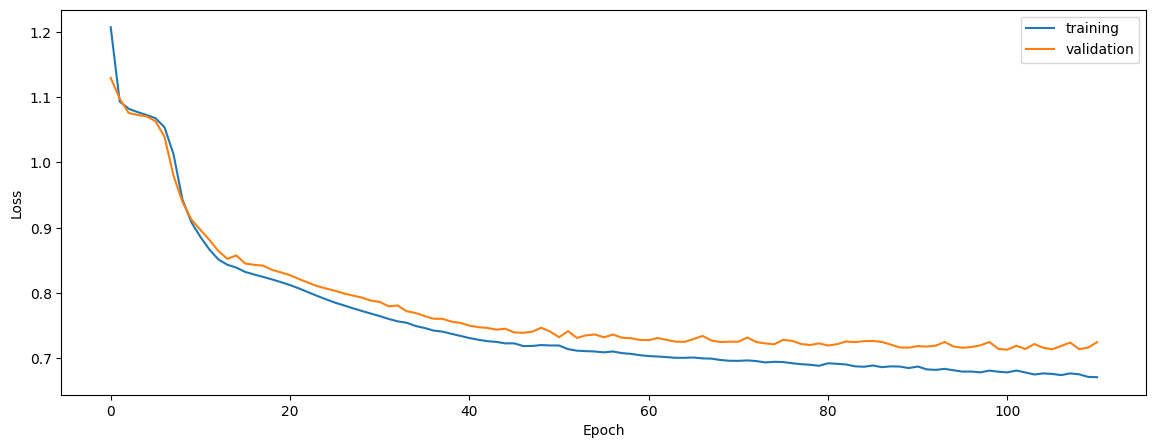

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASH))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.7098797111063825


0.6907810034398748


0.7248878088582223


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.7341037892440482


0.7158618810869714


0.7677727304171375


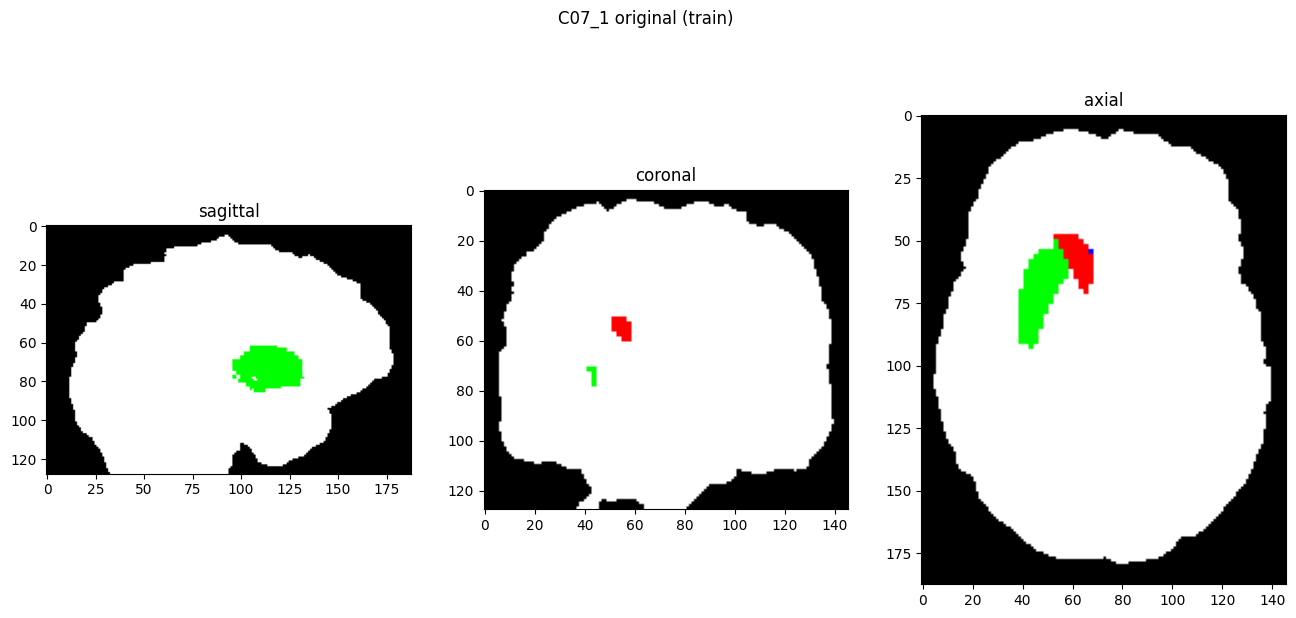

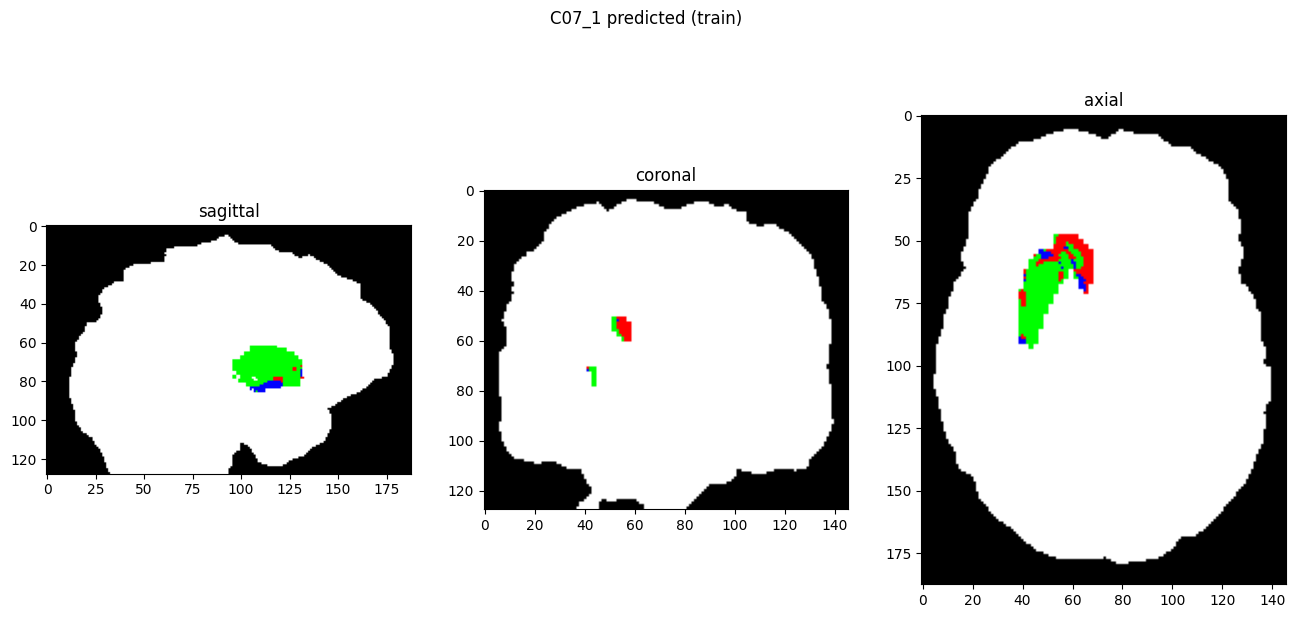

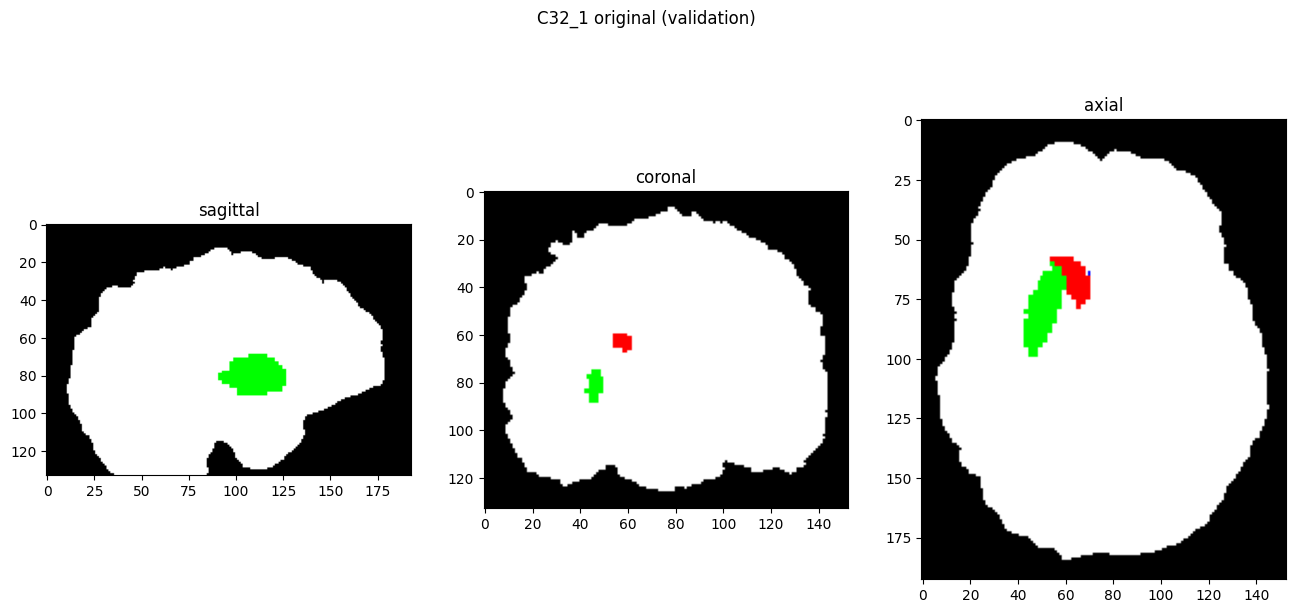

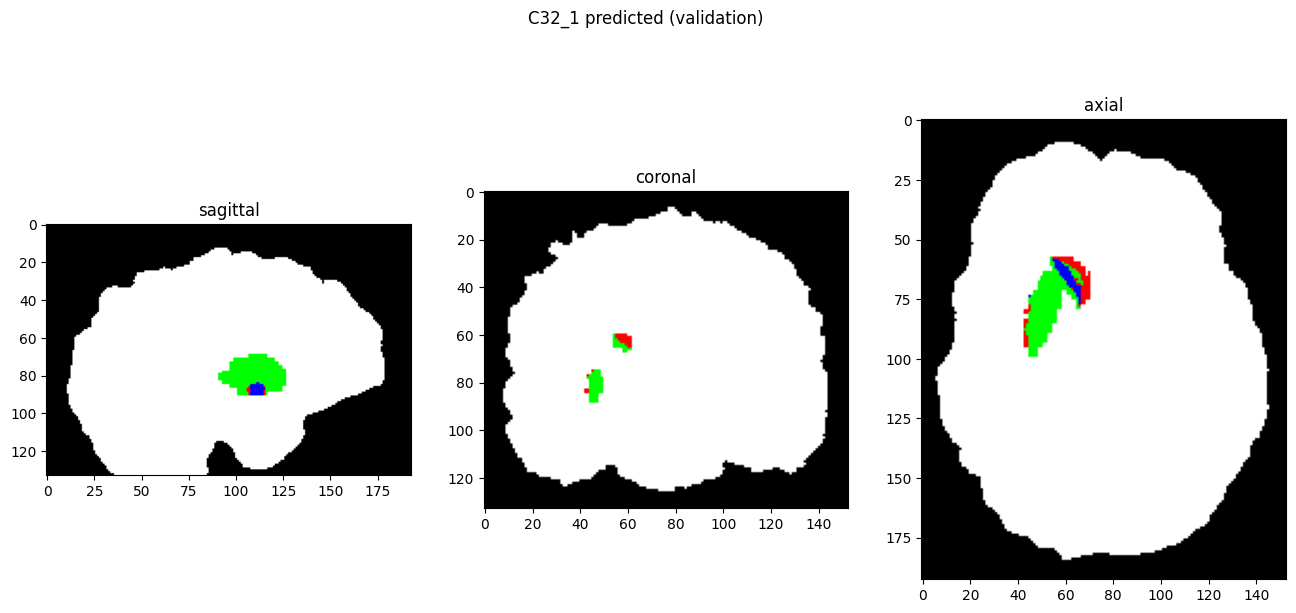

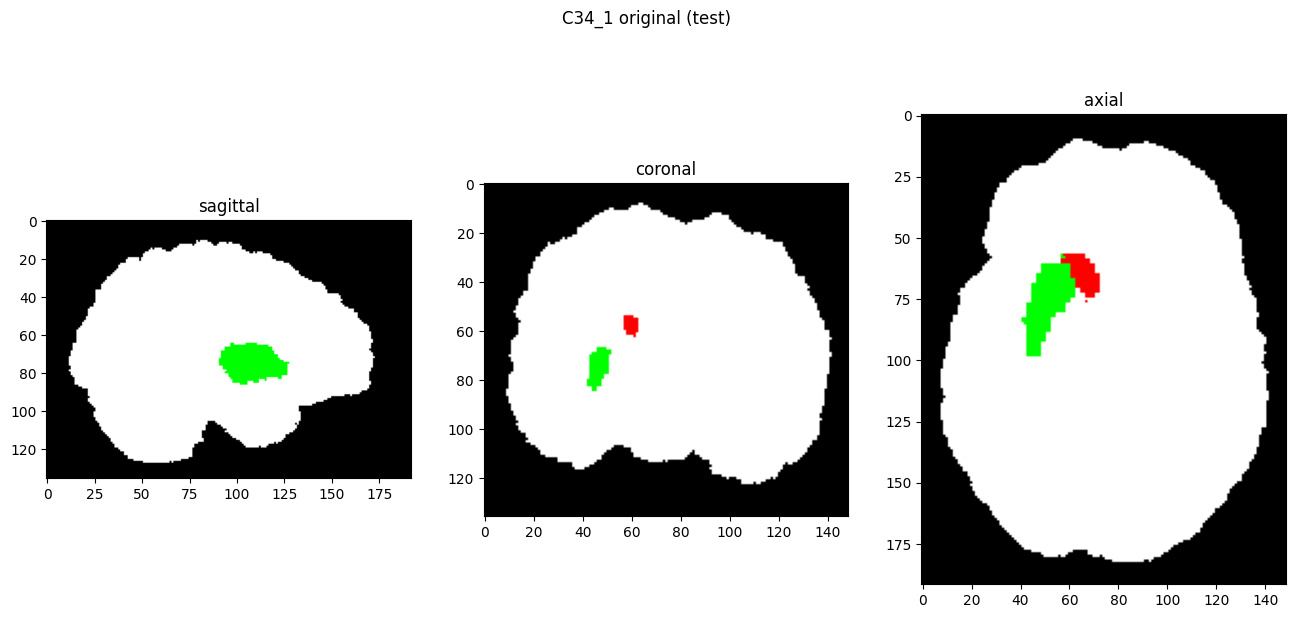

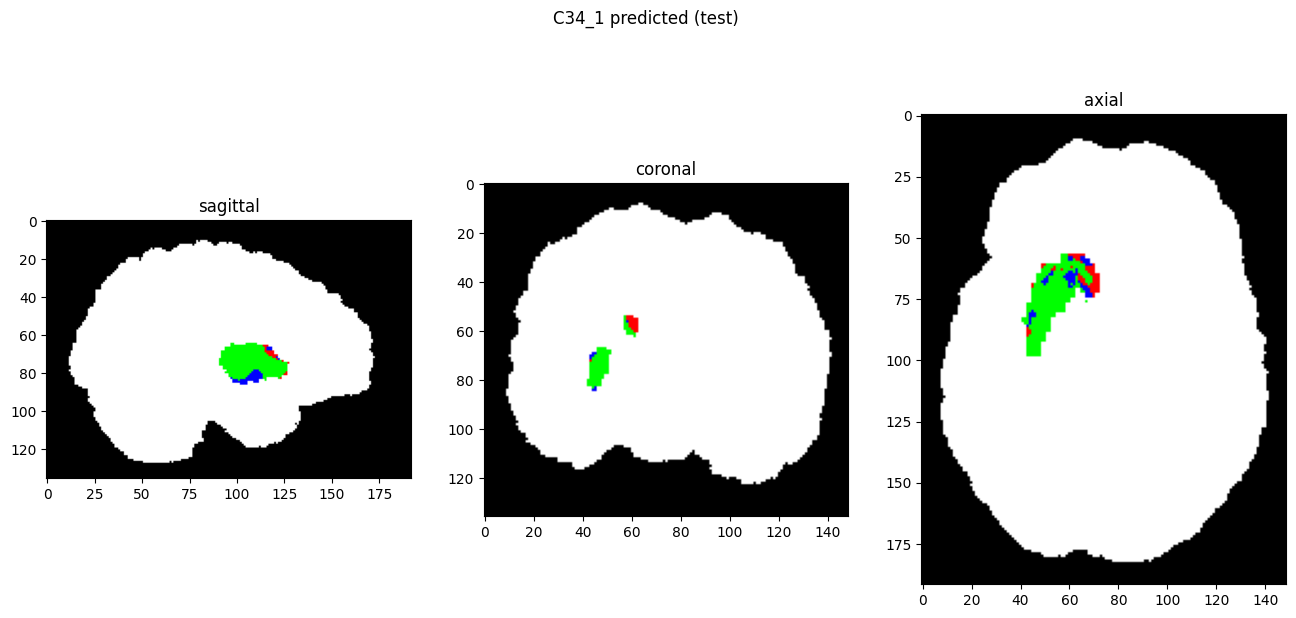

In [9]:
showResults(model, gen, threshold=0)